# Time Series Forecasting Version 1

In this notebook, the goal is to explore the OSA data and predict weekly OSA with 2-week overhead. 

Version 1 will only focus in using a machine learning model called Gradient Boosting. 

On next versions, depending on the results of this notebook, we could explore time series specific models such as ARIMA, Phrophet and ETS.

In [1]:
import sys

sys.path.append('../scripts')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

## Load Data

In [3]:
filepath = '../data/source/2021 NAI MT & RMT OSA Data (GMA All SKUs).xlsx'
df = pd.read_excel(filepath, na_values = ['NC', 'NR', '-', 'NF'])
df.head()

YEAR MONTH    WEEK AREA GROUP    ACCOUNT  \
0  2021   JAN  Week 1  GMA  MT 1   LANDMARK   
1  2021   JAN  Week 1  GMA  MT 1   LANDMARK   
2  2021   JAN  Week 1  GMA  MT 1   LANDMARK   
3  2021   JAN  Week 1  GMA  MT 1  ROBINSONS   
4  2021   JAN  Week 1  GMA  MT 1  ROBINSONS   

                                OUTLET  Amihan White Vinegar 1L (68)  \
0              LANDMARK ALABANG (4341)                           NaN   
1                 LANDMARK MAKATI (53)                           NaN   
2                LANDMARK TRINOMA (54)                           NaN   
3      JAYNITHS SUPERMART PASIG (3368)                           NaN   
4  JAYNITHS SUPERMART SAN MATEO (3373)                           NaN   

   Amihan White Vinegar 2L (69)  Amihan White Vinegar 4L (70)  ...  \
0                           NaN                           NaN  ...   
1                           NaN                           NaN  ...   
2                           NaN                           NaN  ...   
3                           NaN                           NaN  ...   
4                           NaN                           NaN  ...   

   Locally Pink Guava 1L Tetra Pack  Locally Ripe Mango 1L Tetra Pack (512)  \
0                               NaN                                     NaN   
1                               7.0                                     7.0   
2                               7.0                                     7.0   
3                               7.0                                     7.0   
4                               0.0                                     7.0   

   UFC Golden Fiesta Canola 1L SUP (553)  TOTAL AVAILABILITY  MUST CARRY   NC  \
0                                    NaN           85.000000         176   68   
1                                    NaN           97.714286         176   59   
2                                    NaN          108.000000         176   59   
3                                    NaN           55.428571         176  118   
4                                    NaN           54.142857         176  116   

        OSA     CLASS  MUST CARRY - NC  OSA COMPUTATION  
0  0.787037  PARADIGM              108         0.787037  
1  0.835165  PARADIGM              117         0.835165  
2  0.923077  PARADIGM              117         0.923077  
3  0.955665   REGULAR               58         0.955665  
4  0.902381   REGULAR               60         0.902381  

[5 rows x 190 columns]

In [4]:
len(df)

17707

**Observations:** No missing values on the YEAR, MONTH, WEEK, AREA, GROUP, ACCOUNT and OUTLET columns.

In [5]:
# Number of missing
df.isna().sum().head(7)

YEAR       0
MONTH      0
WEEK       0
AREA       0
GROUP      0
ACCOUNT    0
OUTLET     0
dtype: int64

**Observations:** There are SKUs that have all of their entries to be Null ('NC', 'NR', '-', 'NF').

In [6]:
df.isna().sum().sort_values(ascending=False).head(10)

UFC Spaghetti Sauce 750g (45)                                                      17707
LOCALLY JUICE DRINK POMELO FLAVOR 350ML (417)                                      17707
UFC Ready Recipe  Kare - Kare Mix  45g (323)                                       17707
Grande Spaghetti Catsup Pack (UFC SS 1KG + UFC BC 320G SUP + 1PASTA 800G) (412)    17707
DATU PUTI Sugar Cane Vinegar 350ml (331)                                           17707
LOCALLY JUICE DRINK CALAMANSI FLAVOR 350ML (401)                                   17707
LOCALLY JUICE DRINK DALANDAN FLAVOR 350ML (356)                                    17707
LOCALLY JUICE DRINK GUYABANO FLAVOR 350ML (400)                                    17707
UFC Spagg Sauce w/ Real Cheese & Hotdog 250g (269)                                 17707
UFC Spagg Sauce w/ Real Cheese & Hotdog 500g (274)                                 17707
dtype: int64

## Preprocess Data

### Fix Index
- Create index based on datetime (assume 1st monday of week), outlet name

In [7]:
# Create a year-week (e.g. 2022-W1) series
year_week = df['YEAR'].astype('int').astype('str') + '-W' +  df['WEEK'].str.split().str[1]

# Convert year week to datetime
df_clean = df.copy()
df_clean['DATE'] = year_week.apply(utils.convert_year_week_to_date)

# Setting index
df_clean = df_clean.set_index(['OUTLET', 'DATE']).drop(['YEAR', 'MONTH', 'WEEK'], axis=1)

# Sort index
df_clean = df_clean.sort_index()

### Remove SKUs with all Null Records

In [8]:
column_count_before_removal = len(df_clean.columns)
df_clean = df_clean[df_clean.columns[df_clean.isna().sum() != len(df)]]
print(f"There were {column_count_before_removal-len(df_clean.columns)} SKUs removed.")

There were 30 SKUs removed.


### Filling Null values with -1
Note: Given we will be using a tree-based algorithm, this would mitigate the problem that could arise from this.
We used -1 to differentiate it with 0. 

In [9]:
df_clean = df_clean.fillna(-1)
df_clean.sample(5)

AREA GROUP  \
OUTLET                                            DATE                    
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13  GMA  MT 2   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08  GMA  MT 5   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30  GMA  MT 2   
LANDMARK TRINOMA (54)                             2021-01-04  GMA  MT 1   
RS SPARK PLACE CUBAO (3196)                       2021-03-29  GMA  MT 1   

                                                                ACCOUNT  \
OUTLET                                            DATE                    
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13       SSMI   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08   PUREGOLD   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30       SMCO   
LANDMARK TRINOMA (54)                             2021-01-04   LANDMARK   
RS SPARK PLACE CUBAO (3196)                       2021-03-29  ROBINSONS   

                                                              Amihan White Vinegar 4L (70)  \
OUTLET                                            DATE                                       
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13                           7.0   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08                          -1.0   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30                          -1.0   
LANDMARK TRINOMA (54)                             2021-01-04                          -1.0   
RS SPARK PLACE CUBAO (3196)                       2021-03-29                          -1.0   

                                                              DATU PUTI Magic 250ml (311)  \
OUTLET                                            DATE                                      
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13                         -1.0   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08                         -1.0   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30                         -1.0   
LANDMARK TRINOMA (54)                             2021-01-04                          7.0   
RS SPARK PLACE CUBAO (3196)                       2021-03-29                         -1.0   

                                                              DATU PUTI Mansi 250ml (312)  \
OUTLET                                            DATE                                      
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13                         -1.0   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08                         -1.0   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30                         -1.0   
LANDMARK TRINOMA (54)                             2021-01-04                          7.0   
RS SPARK PLACE CUBAO (3196)                       2021-03-29                         -1.0   

                                                              Datu Puti Oysterrific Oyster Sauce 30g (262)  \
OUTLET                                            DATE                                                       
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 2021-12-13                                           7.0   
PUREGOLD MINI MART - BIGLANG AWA (4704)           2021-11-08                                           7.0   
SMC-SAVEMORE CYBERWEST Q.C (3665)                 2021-08-30                                           7.0   
LANDMARK TRINOMA (54)                             2021-01-04                                           7.0   
RS SPARK PLACE CUBAO (3196)                       2021-03-29                                           0.0   

                                                              Datu Puti Oysterrific Oyster Sauce 170g (263)  \
OUTLET                                            DATE                                                        
SSMI - SM HYPERMARKET CHERRY CONGRESSIONAL (3656) 202

## Prepare Data for Prediction

In [11]:
other_cols = ['TOTAL AVAILABILITY', 'MUST CARRY', 'NC', 'OSA', 'CLASS', 'MUST CARRY - NC', 'OSA COMPUTATION', 'GROUP', 'ACCOUNT', 'AREA']
OSA_cols = list(set(df_clean.columns) - set(other_cols))

## EDA

### What is the distribution of individual OSA values?

Based on the plots below, generally the values are -1, 0 or 7. 
This just shows how binary the values of OSA is (disregarding -1 as it means Null). Maybe in the future, we can use a binary specific model to predict.

The same is also true for the OSA for each outlet. Check Appendix A.

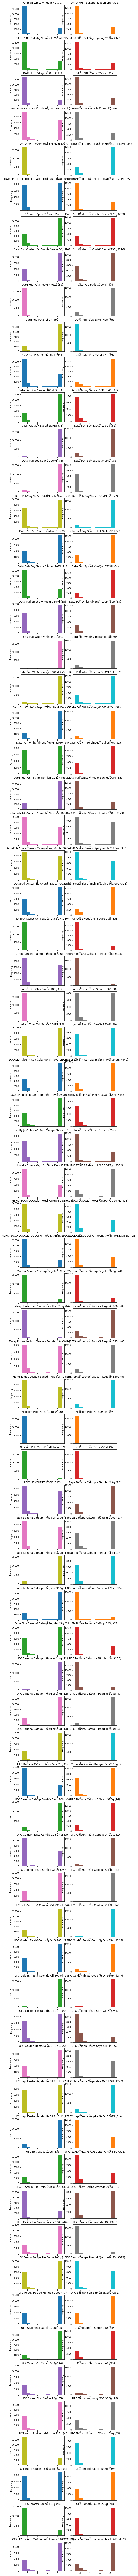

In [12]:
row = 73
col = 2
df_clean[sorted(OSA_cols)].plot.hist(subplots=True, 
                                     layout=(row, col), 
                                     figsize=(col*4, row*3),
                                     legend=False,
                                     title=sorted(OSA_cols), 
                                     sharex=False);

## Prepare Data for Prediction

## Time Series Prediction

## Appendix

### Appendix A. What is the distribution of OSA per outlet?

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


OUTLET
FREE CHOICE PASIG (3673)                 AxesSubplot(0.125,0.125;0.775x0.755)
GROCER E SUPERMART - PANORAMA (266)      AxesSubplot(0.125,0.125;0.775x0.755)
GROCER E SUPERMART - STA. ELENA (265)    AxesSubplot(0.125,0.125;0.775x0.755)
JAYNITHS SUPERMART PASIG (3368)          AxesSubplot(0.125,0.125;0.775x0.755)
JAYNITHS SUPERMART SAN MATEO (3373)      AxesSubplot(0.125,0.125;0.775x0.755)
                                                         ...                 
WALTERMART VISAYAS AVE. (4892)           AxesSubplot(0.125,0.125;0.775x0.755)
WELLCOME ALABANG HILLS (3395)            AxesSubplot(0.125,0.125;0.775x0.755)
WELLCOME FARMERS CUBAO (3411)            AxesSubplot(0.125,0.125;0.775x0.755)
WELLCOME G TUAZON (3437)                 AxesSubplot(0.125,0.125;0.775x0.755)
WELLCOME MANHATAN CUBAO (4263)           AxesSubplot(0.125,0.125;0.775x0.755)
Length: 458, dtype: object

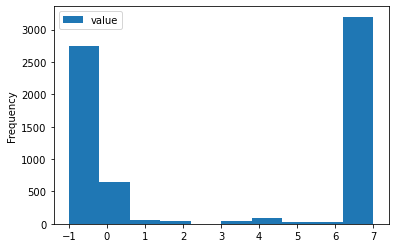

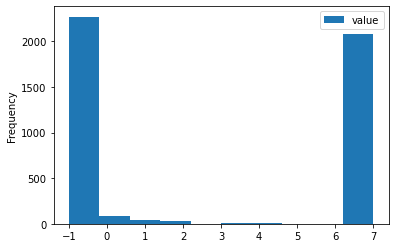

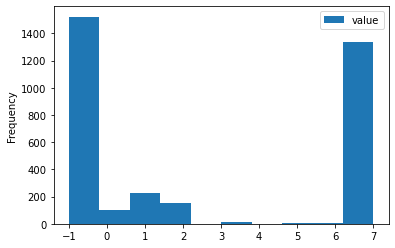

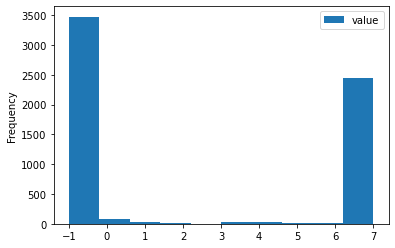

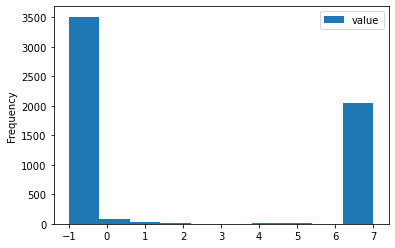

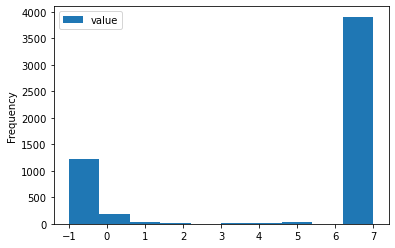

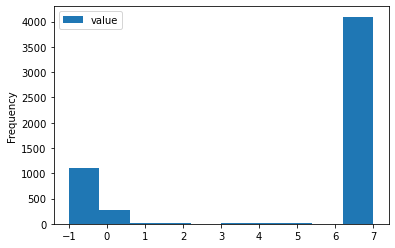

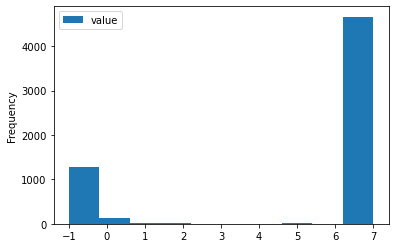

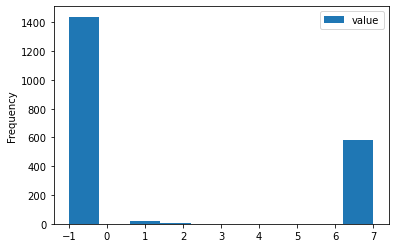

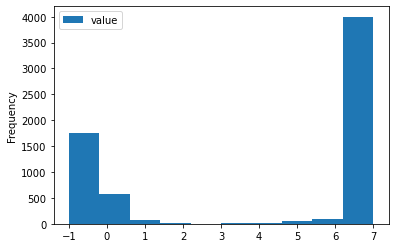

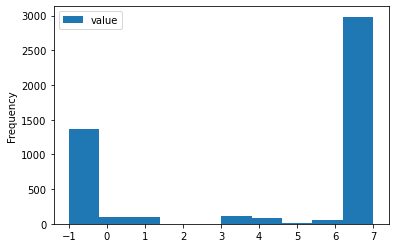

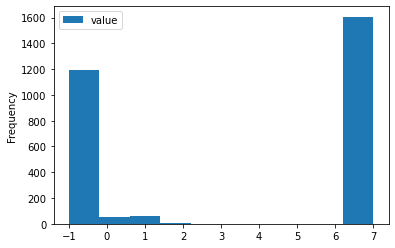

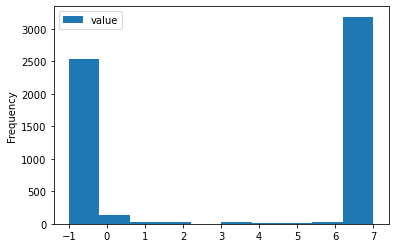

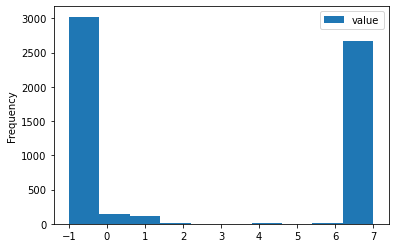

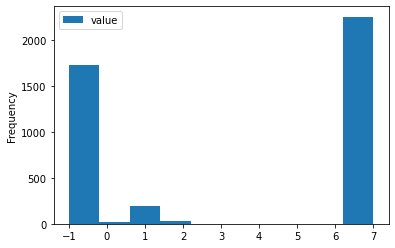

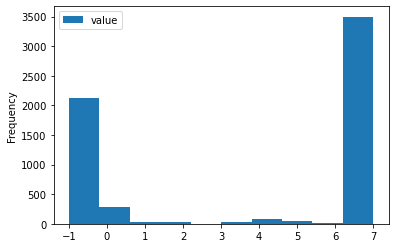

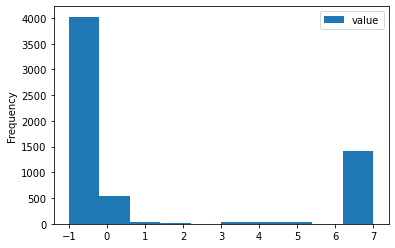

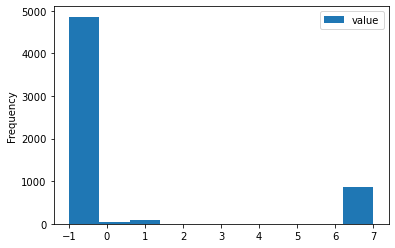

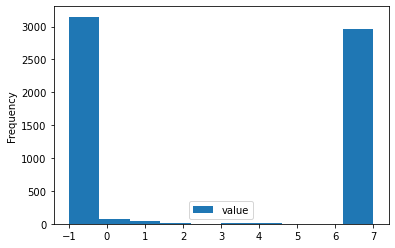

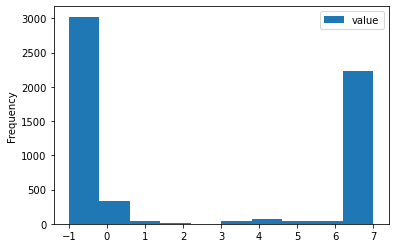

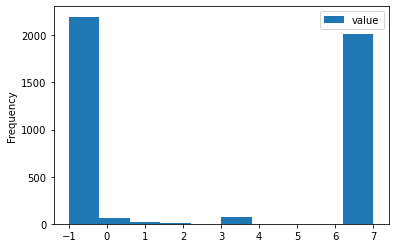

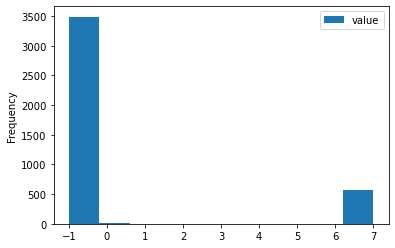

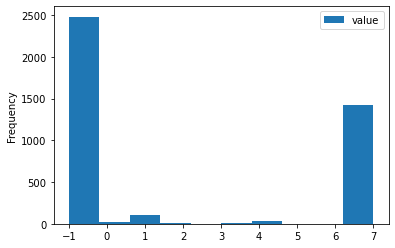

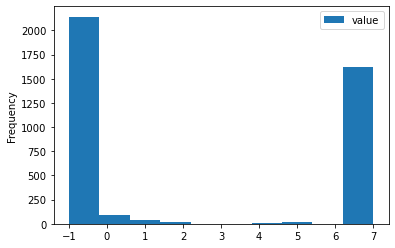

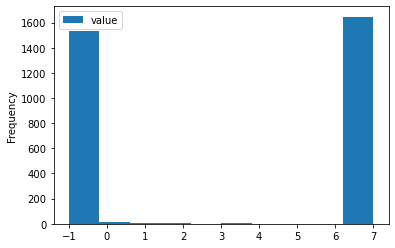

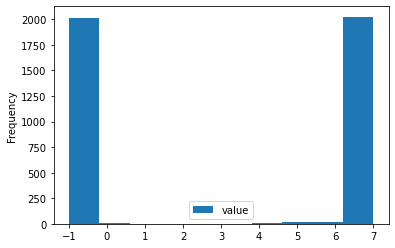

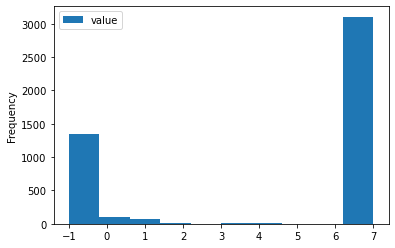

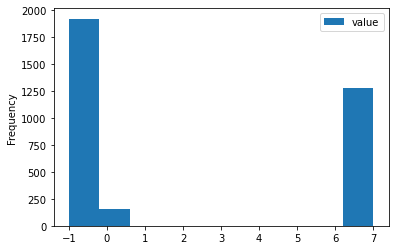

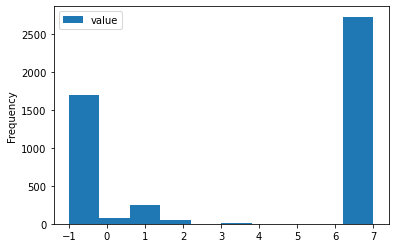

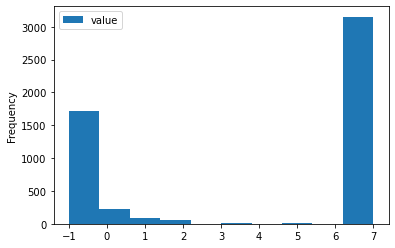

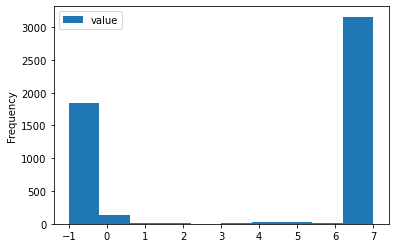

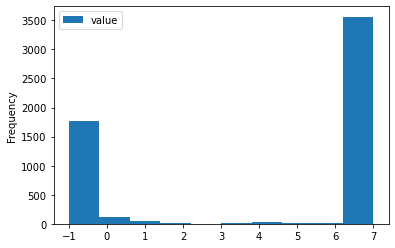

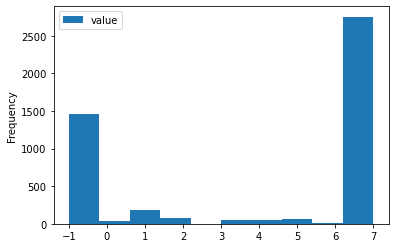

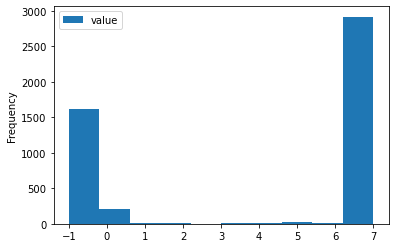

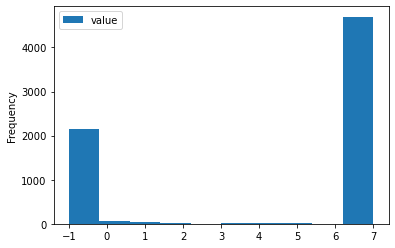

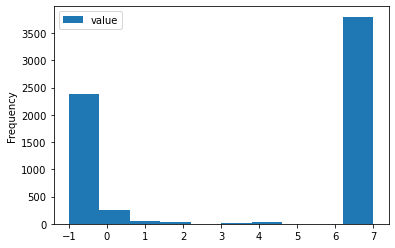

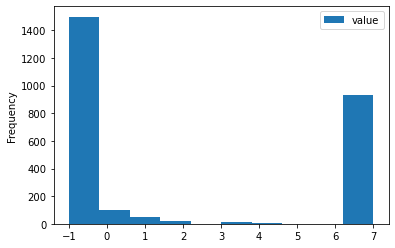

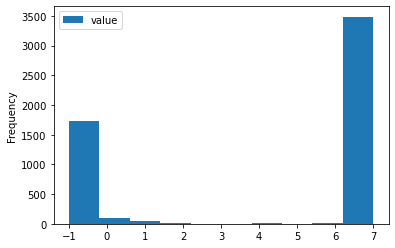

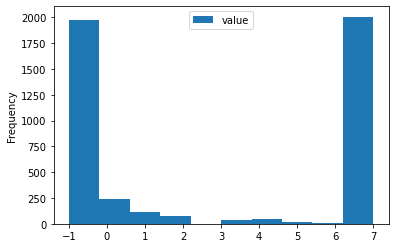

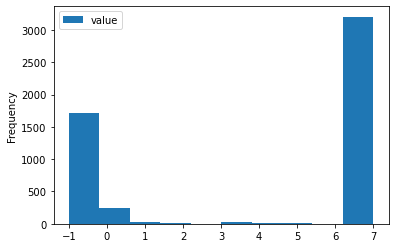

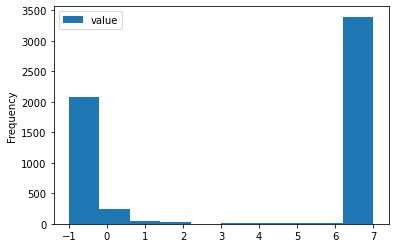

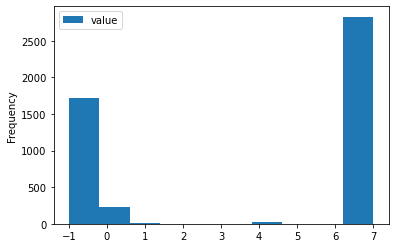

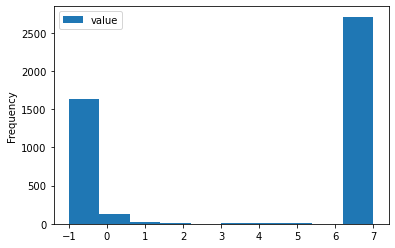

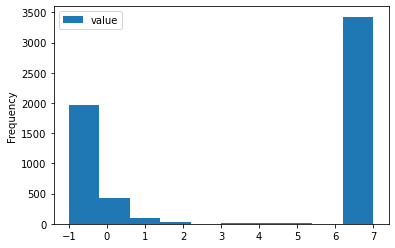

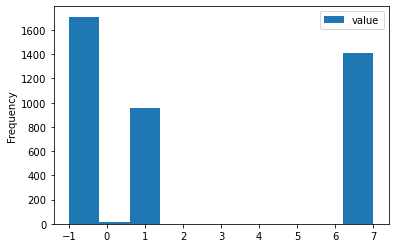

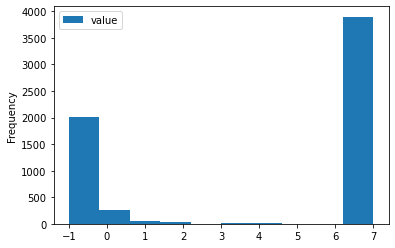

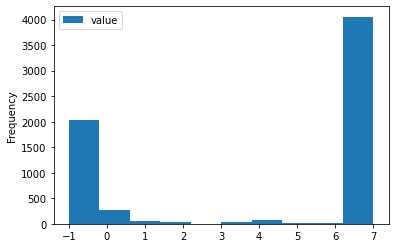

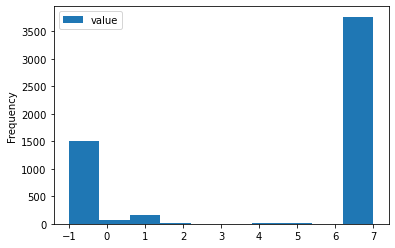

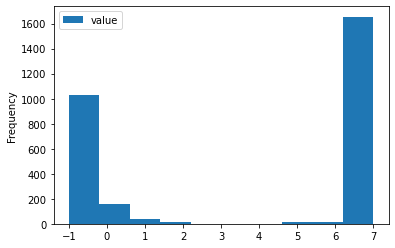

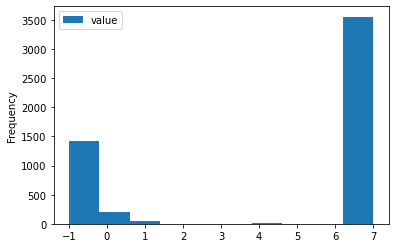

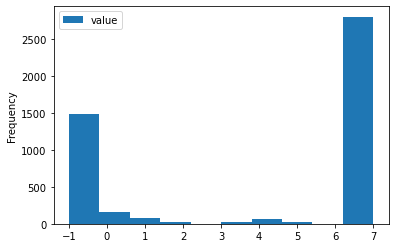

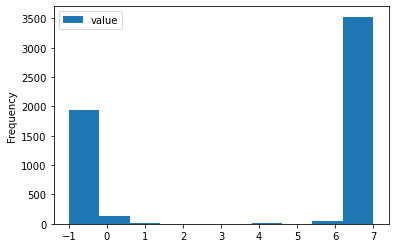

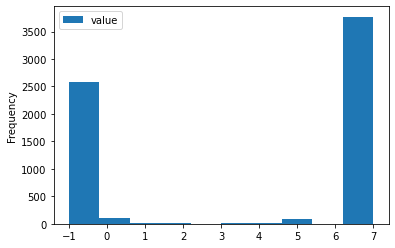

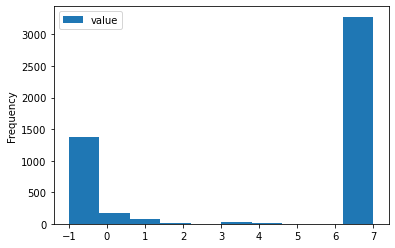

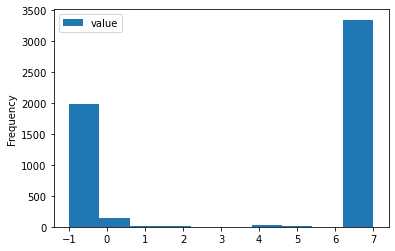

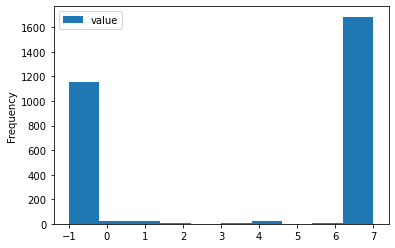

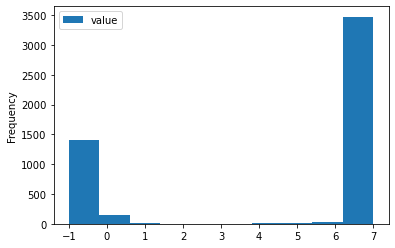

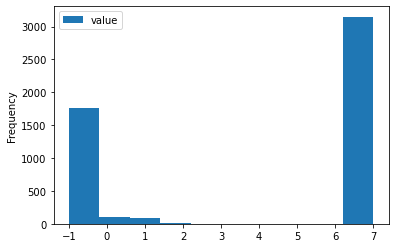

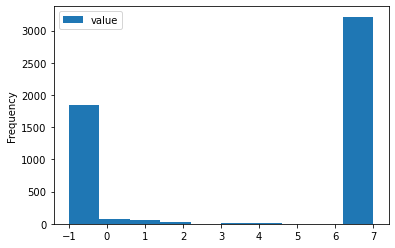

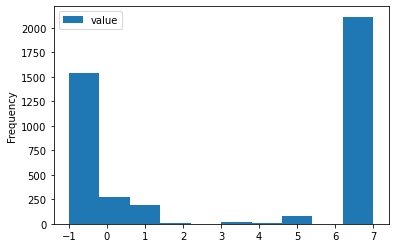

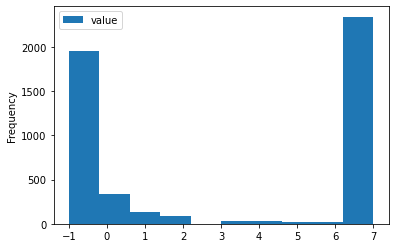

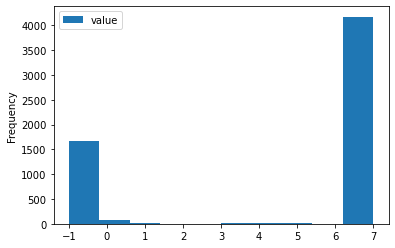

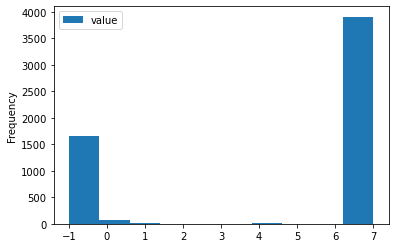

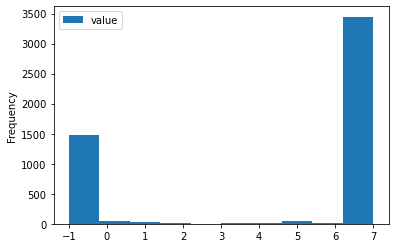

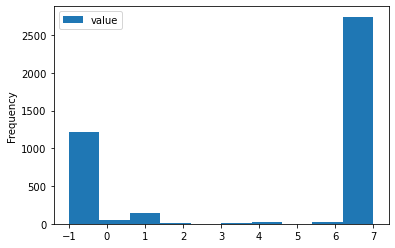

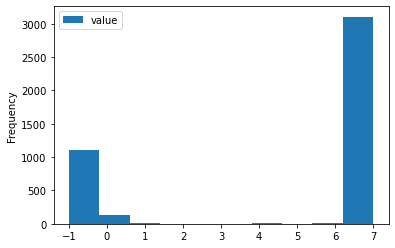

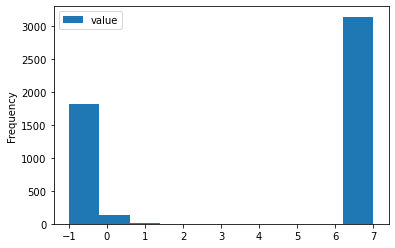

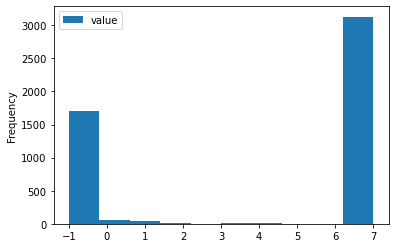

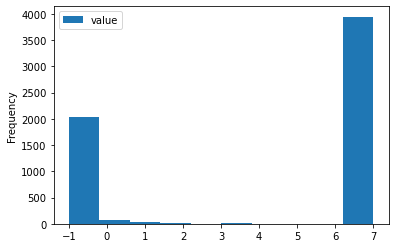

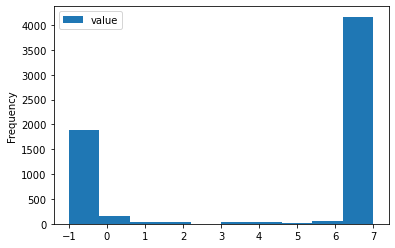

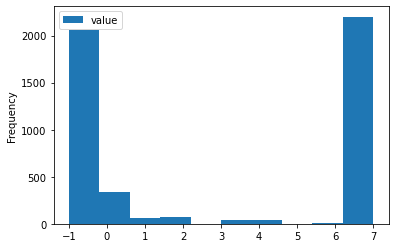

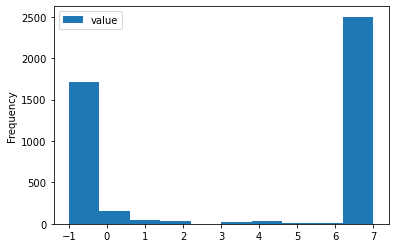

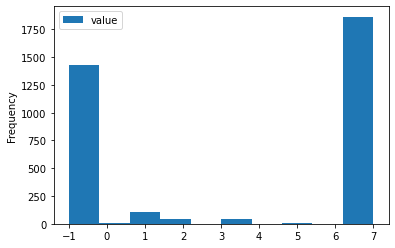

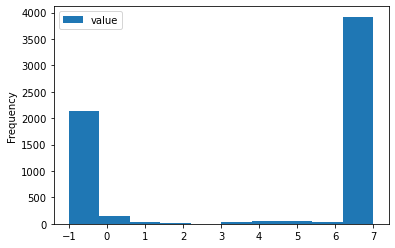

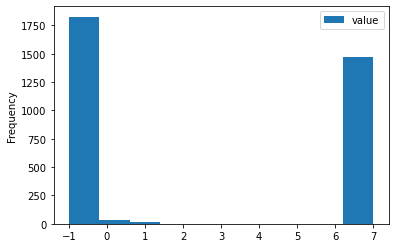

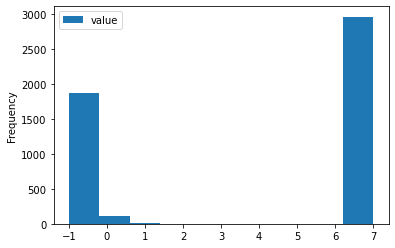

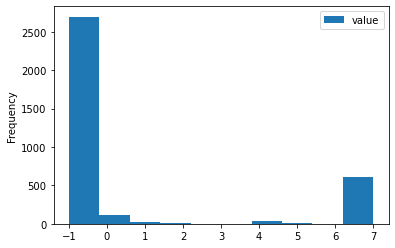

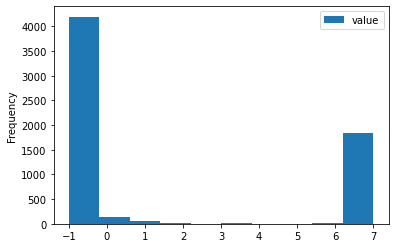

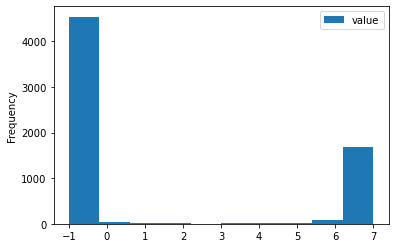

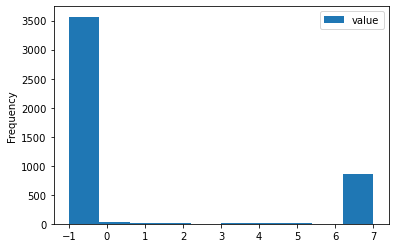

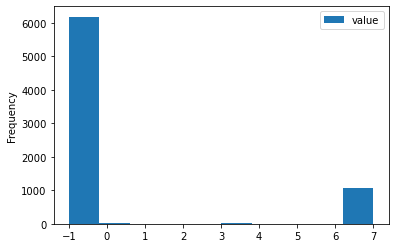

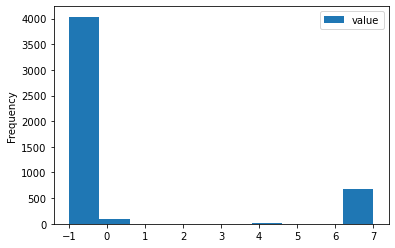

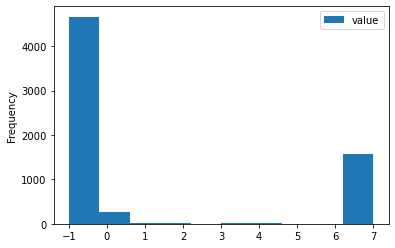

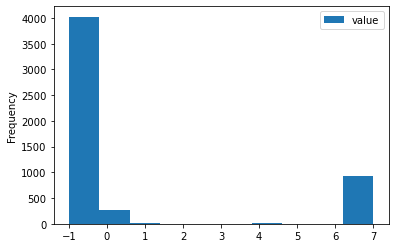

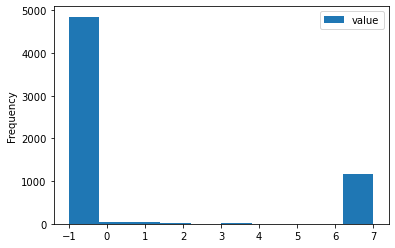

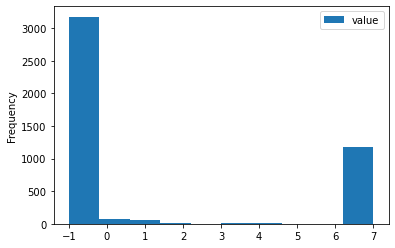

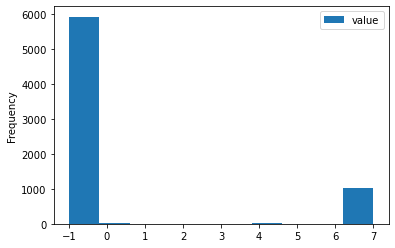

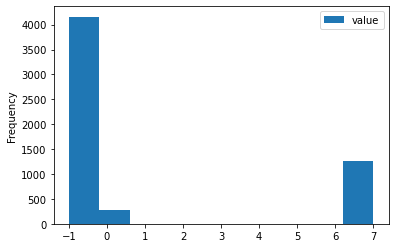

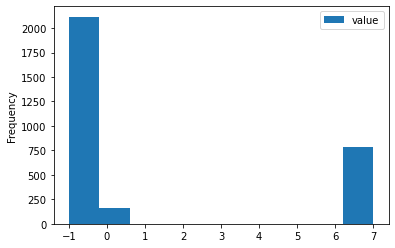

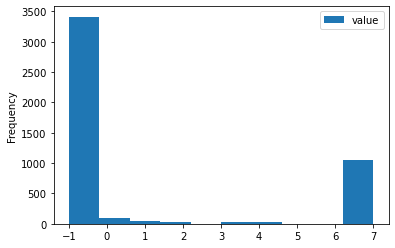

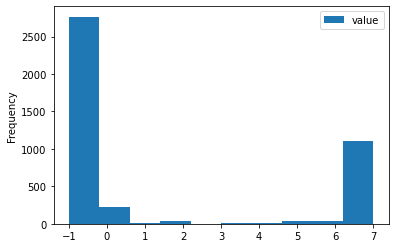

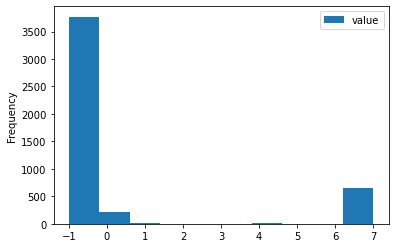

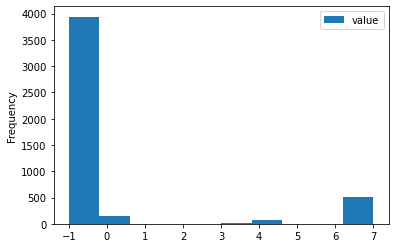

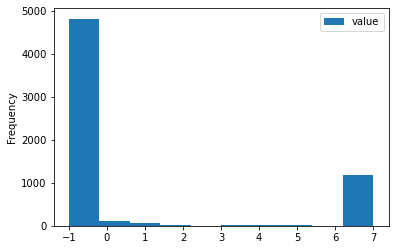

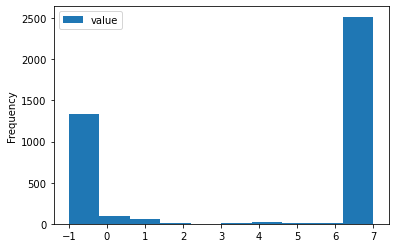

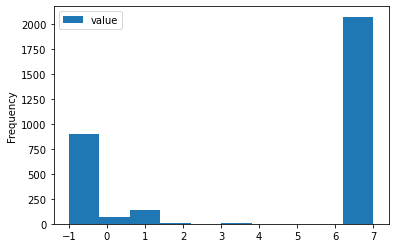

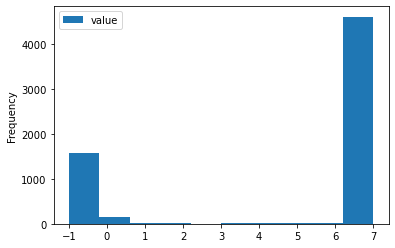

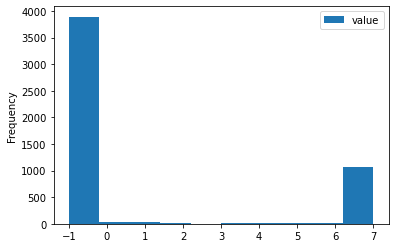

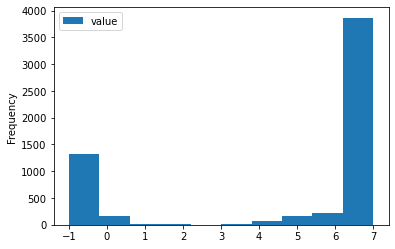

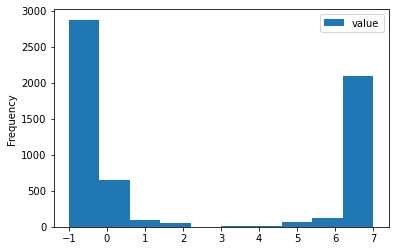

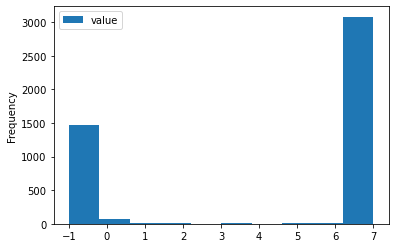

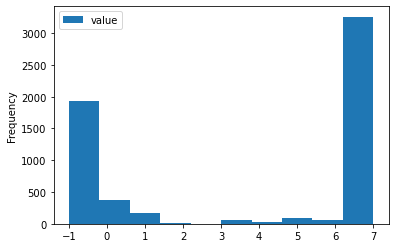

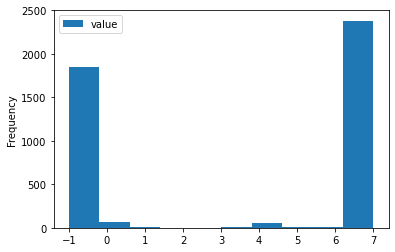

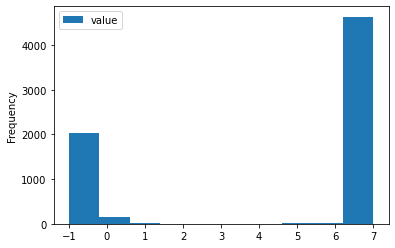

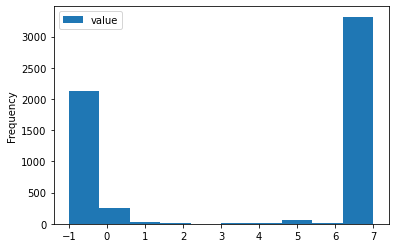

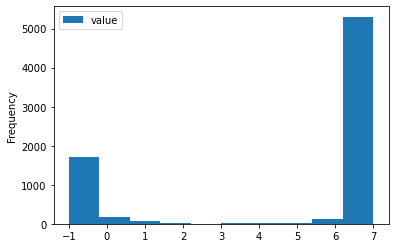

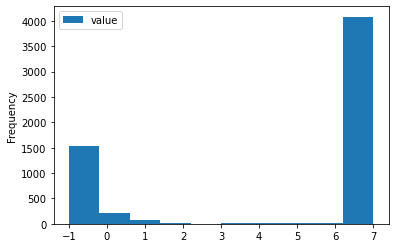

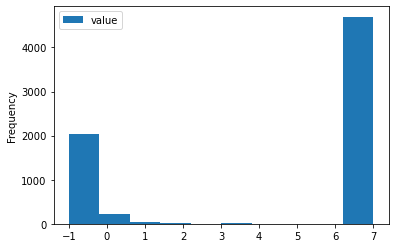

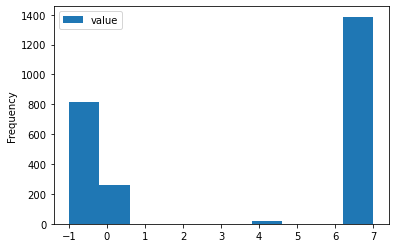

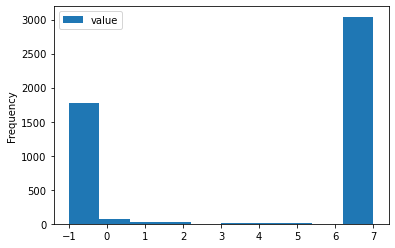

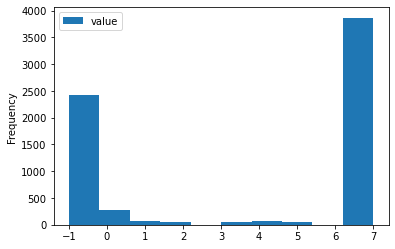

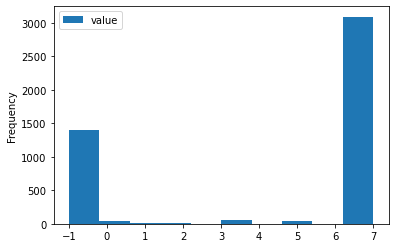

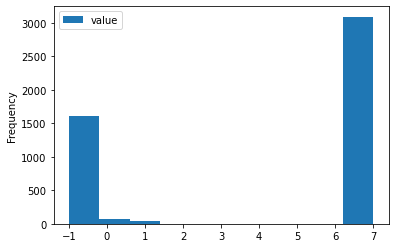

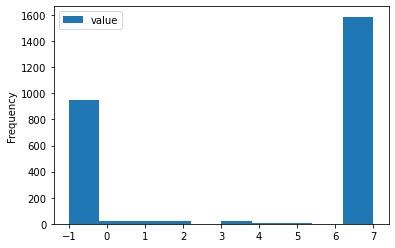

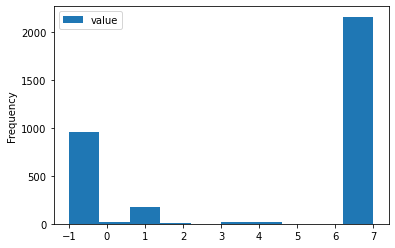

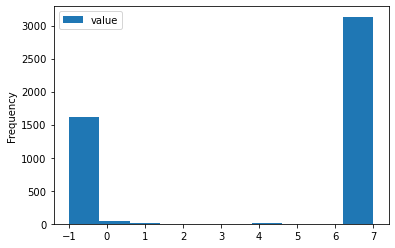

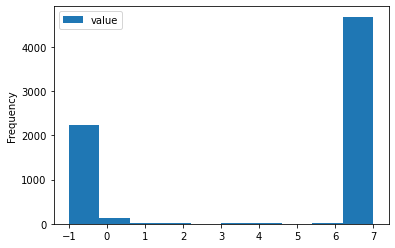

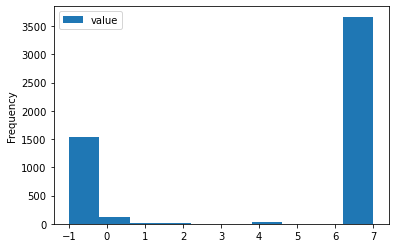

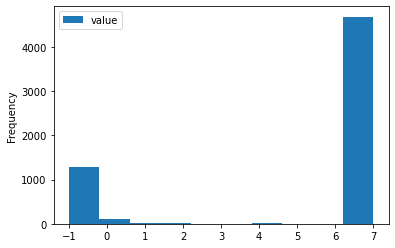

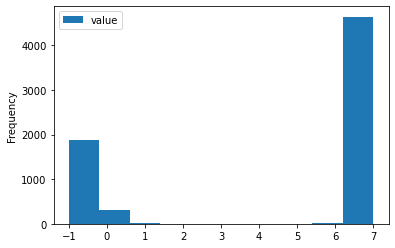

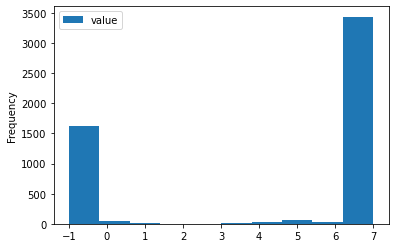

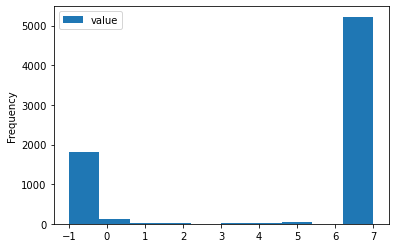

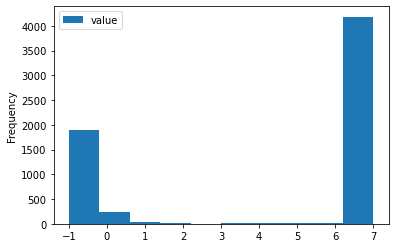

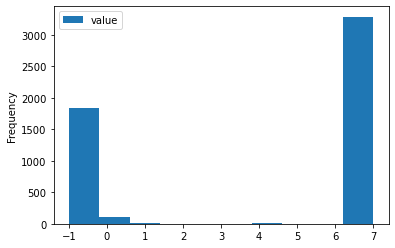

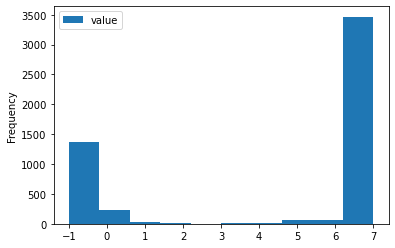

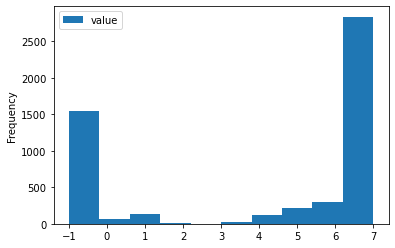

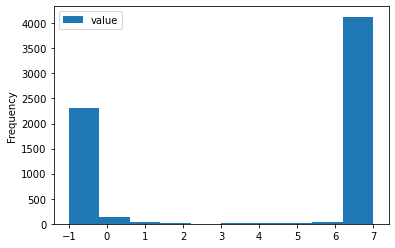

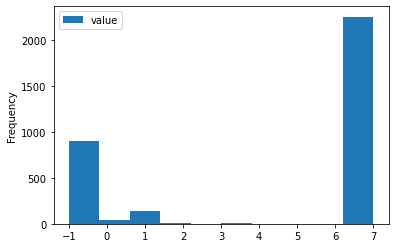

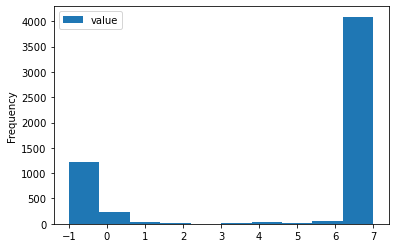

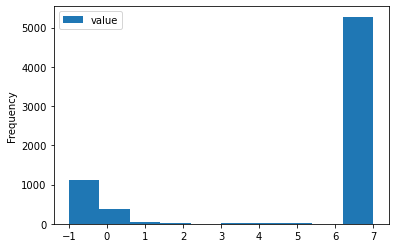

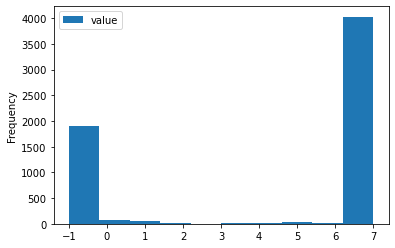

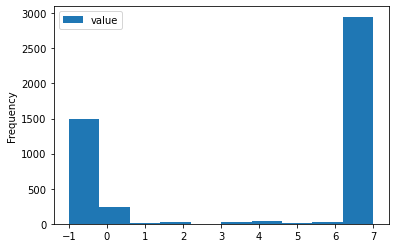

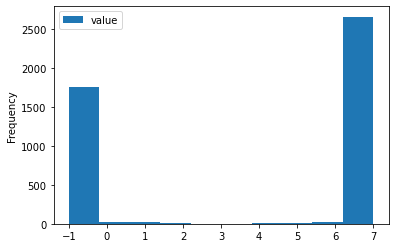

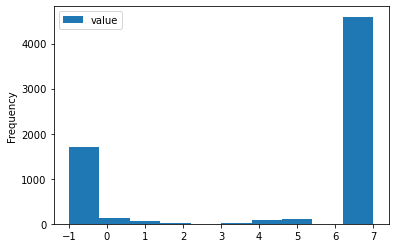

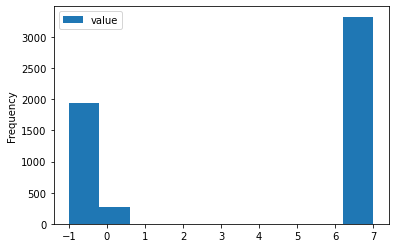

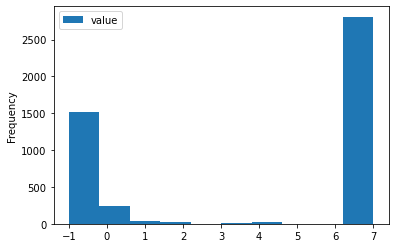

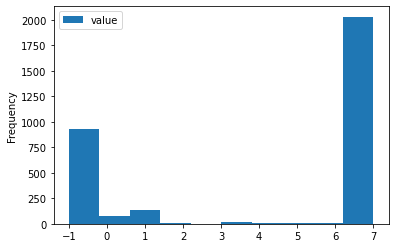

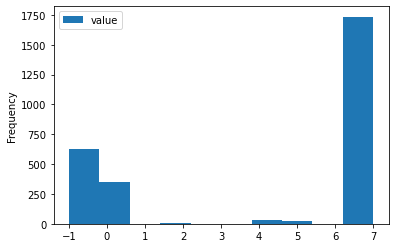

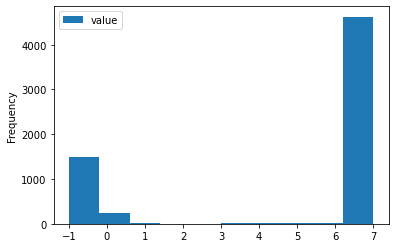

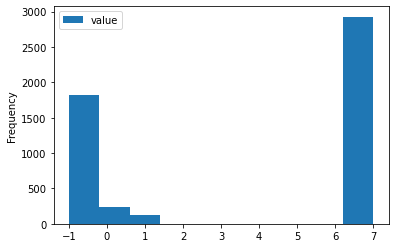

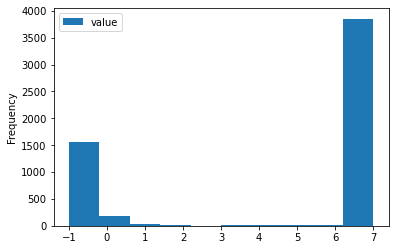

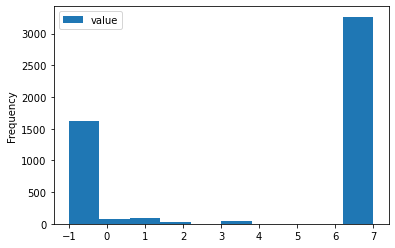

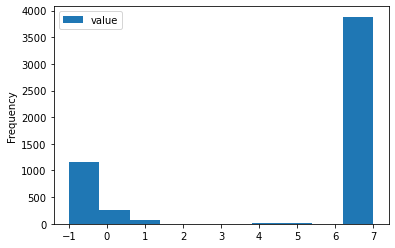

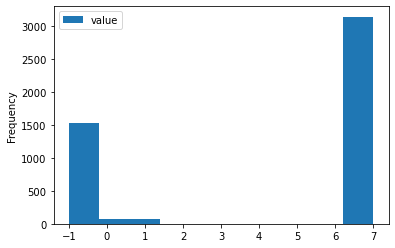

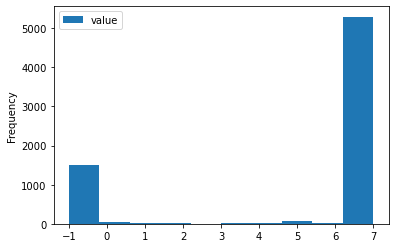

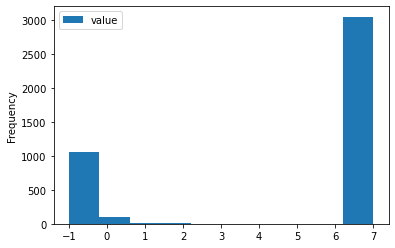

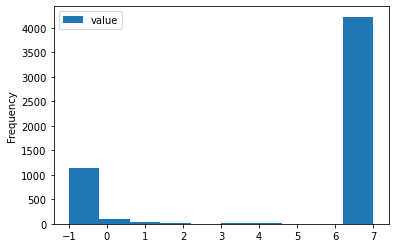

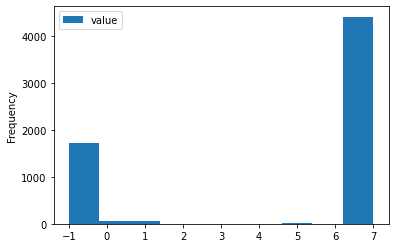

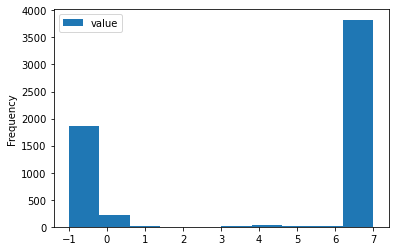

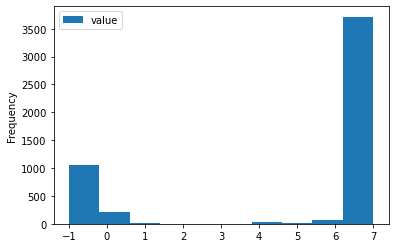

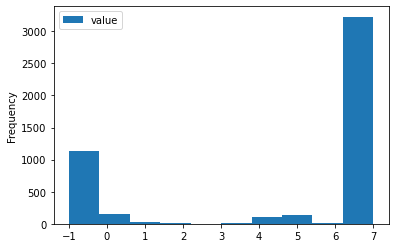

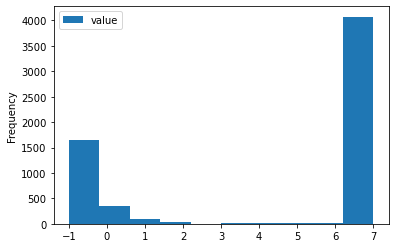

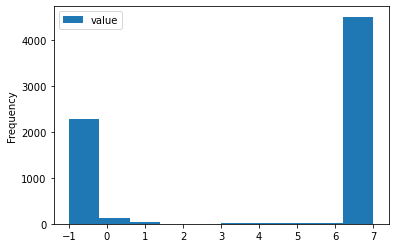

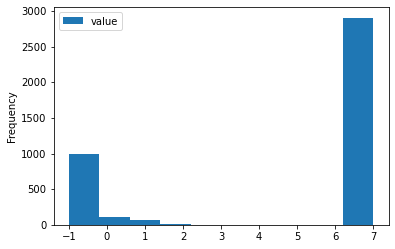

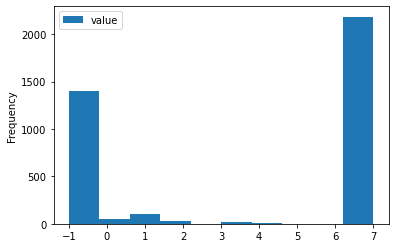

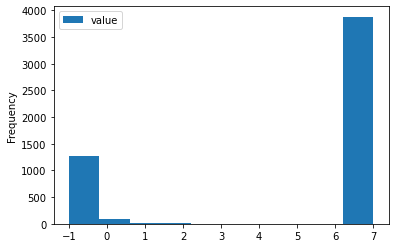

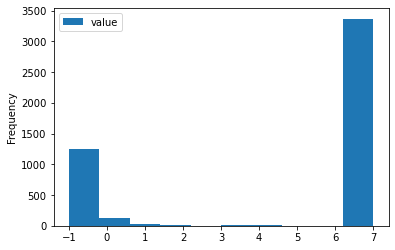

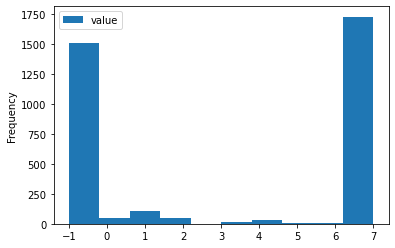

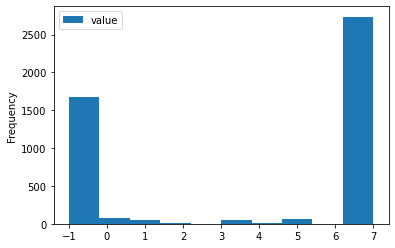

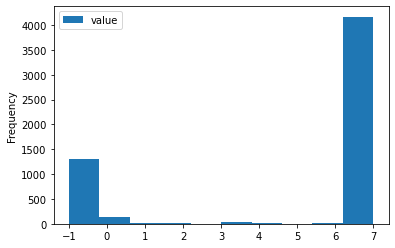

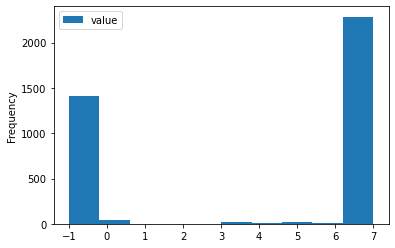

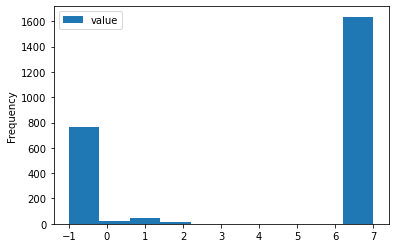

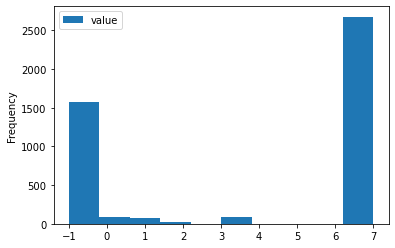

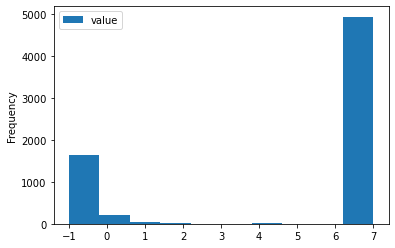

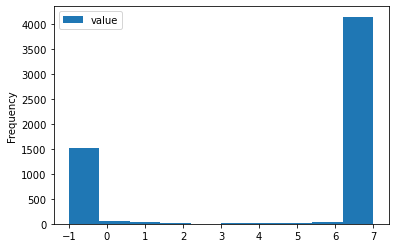

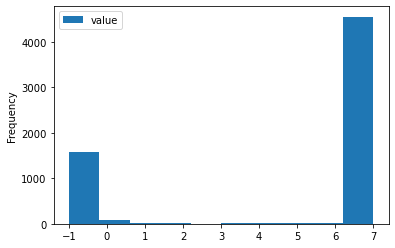

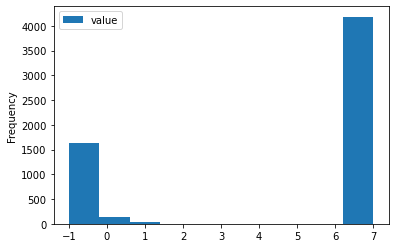

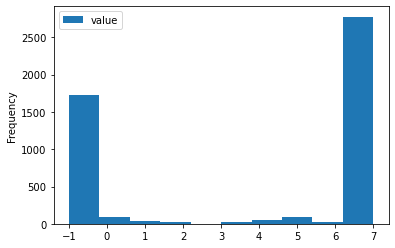

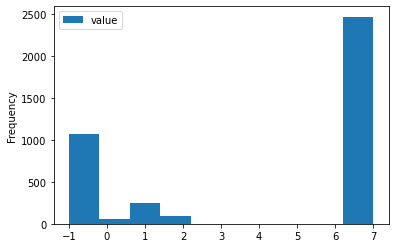

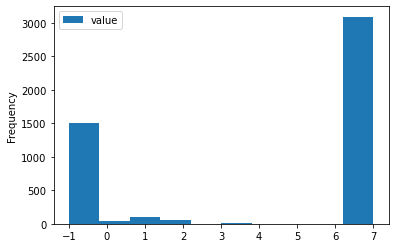

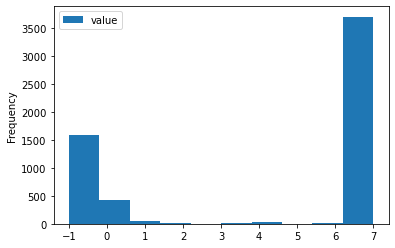

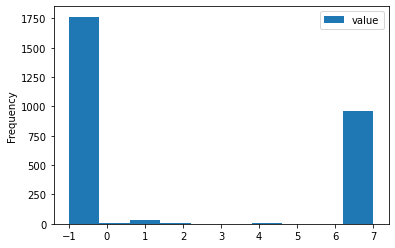

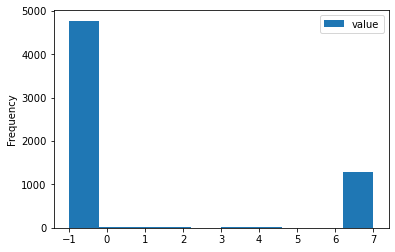

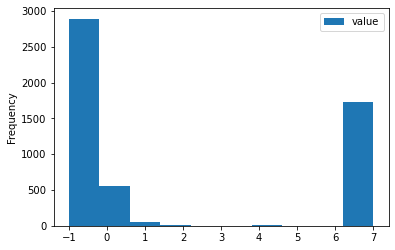

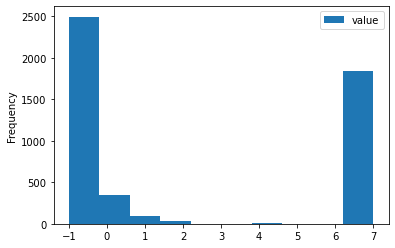

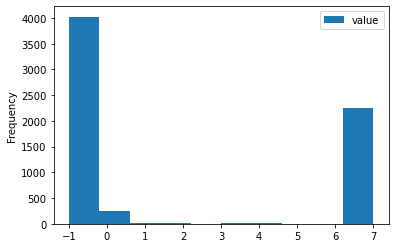

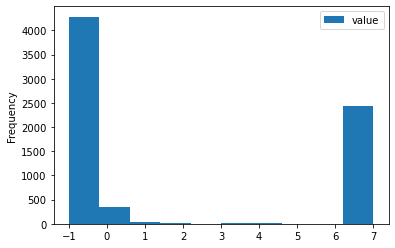

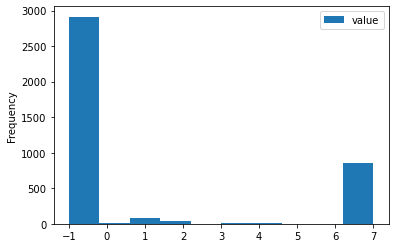

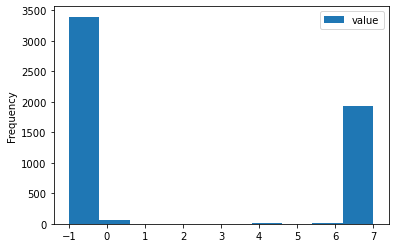

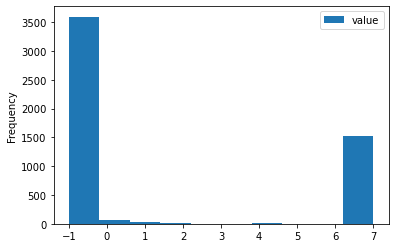

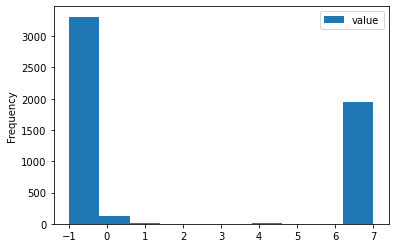

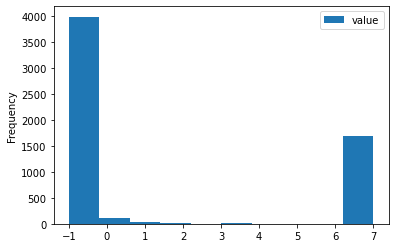

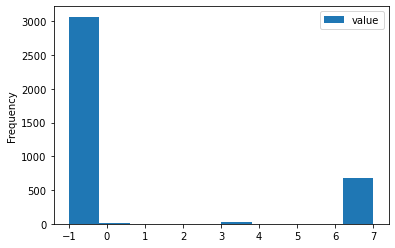

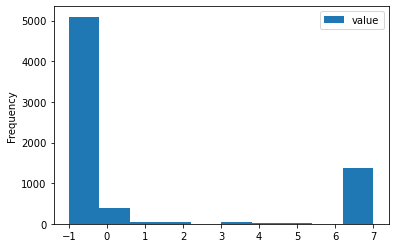

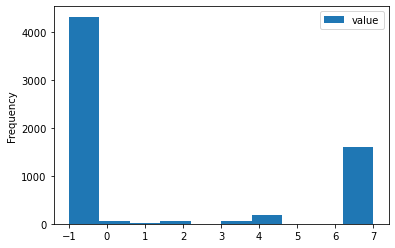

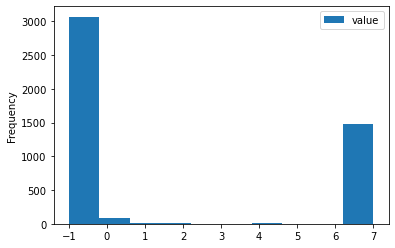

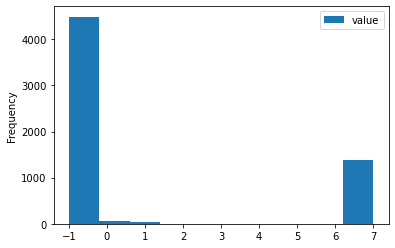

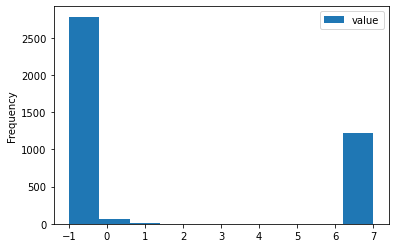

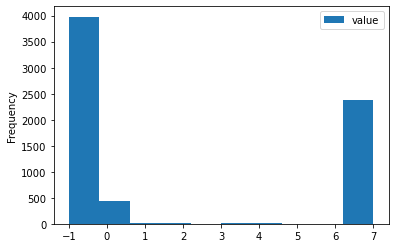

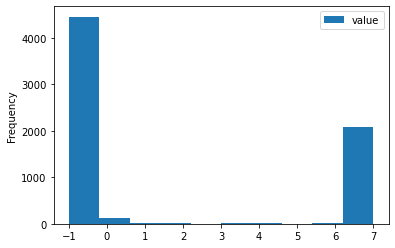

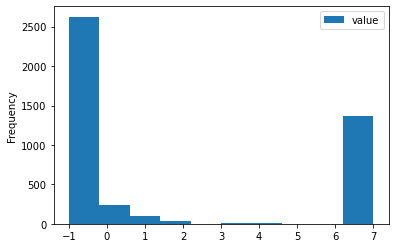

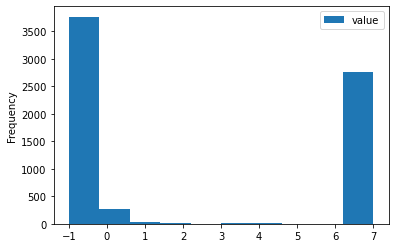

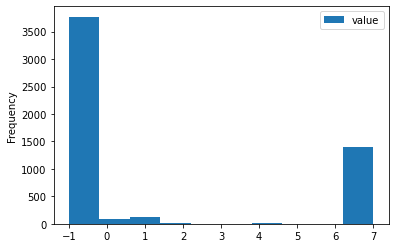

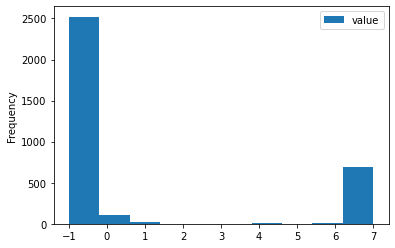

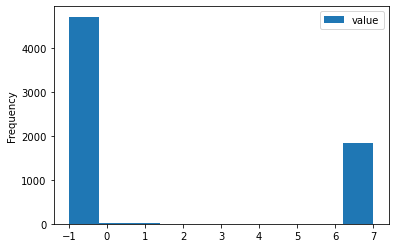

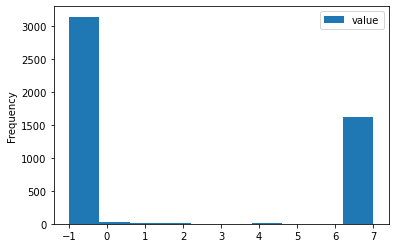

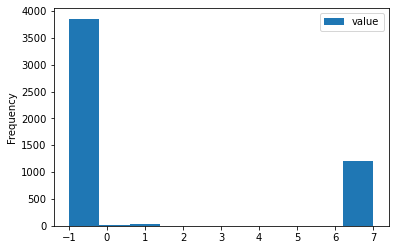

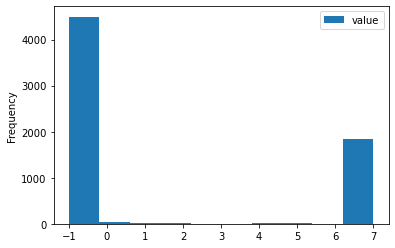

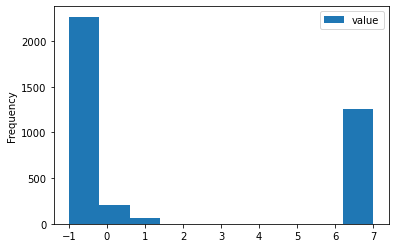

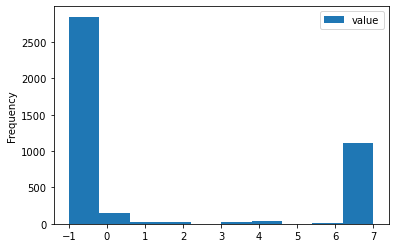

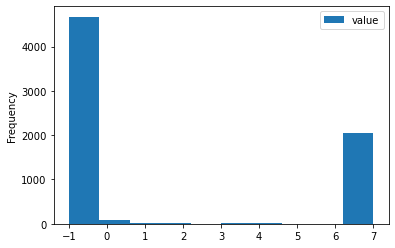

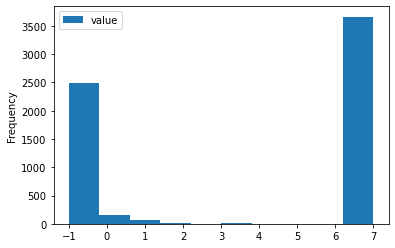

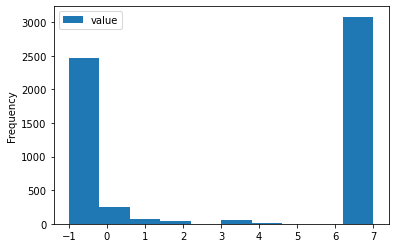

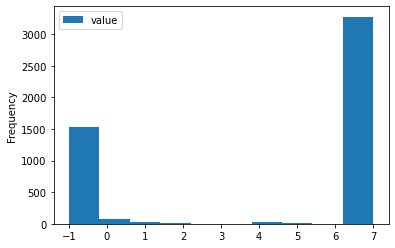

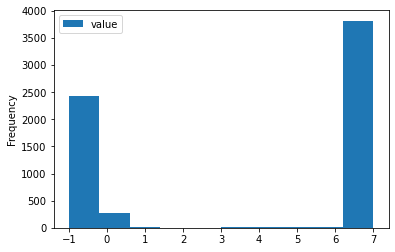

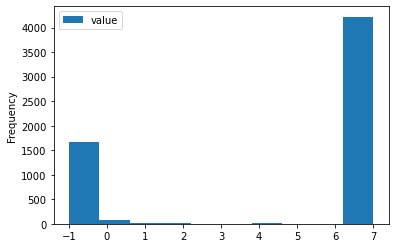

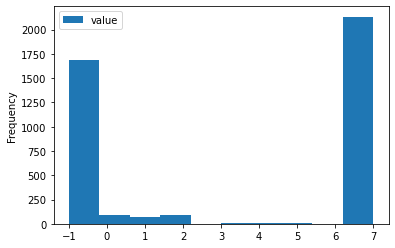

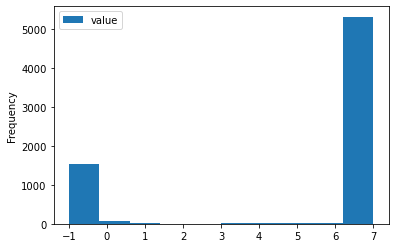

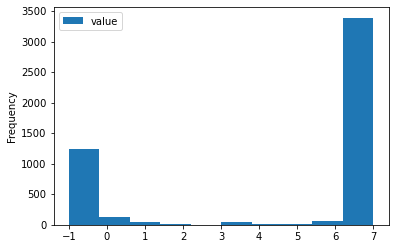

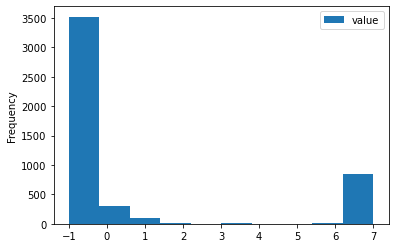

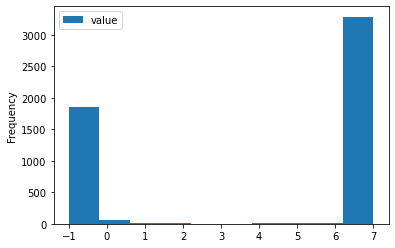

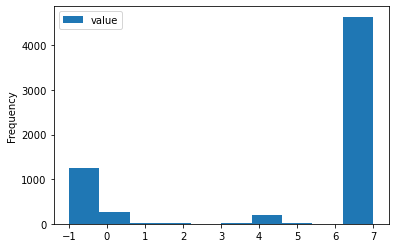

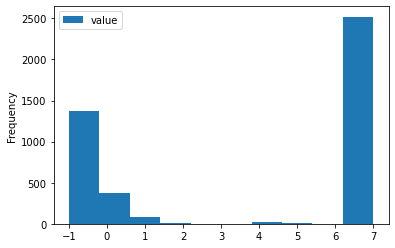

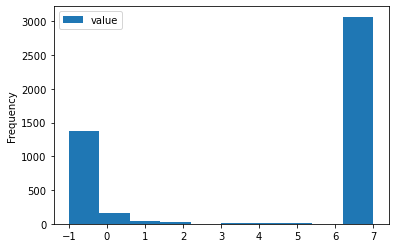

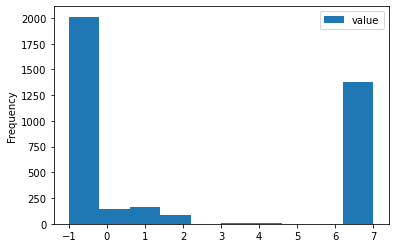

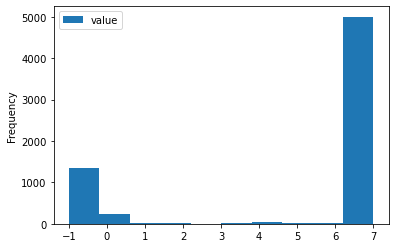

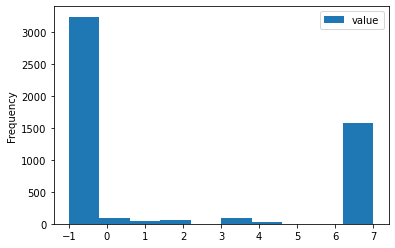

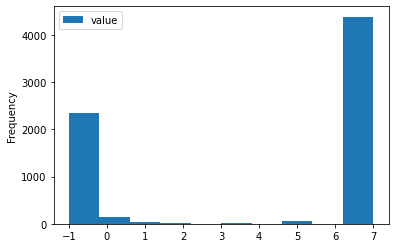

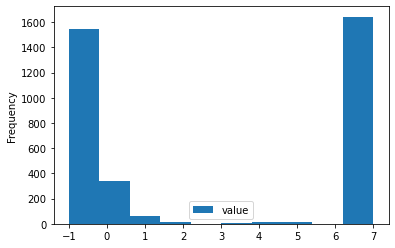

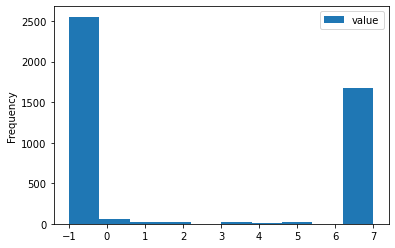

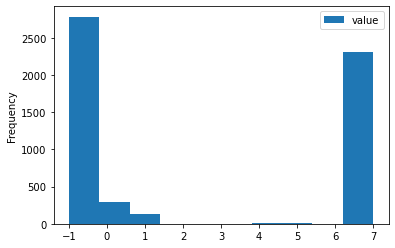

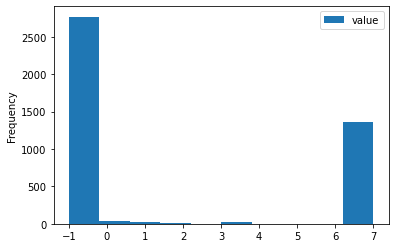

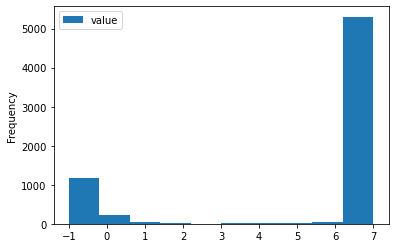

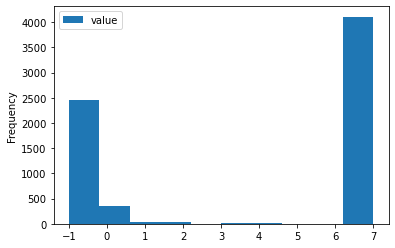

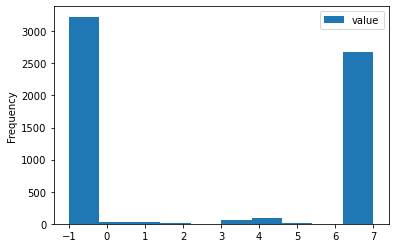

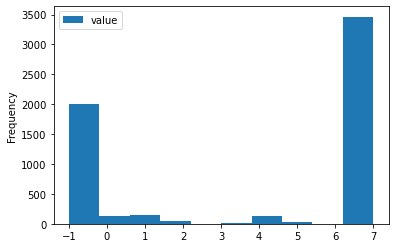

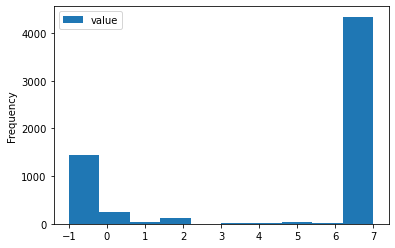

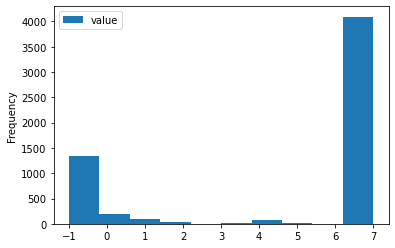

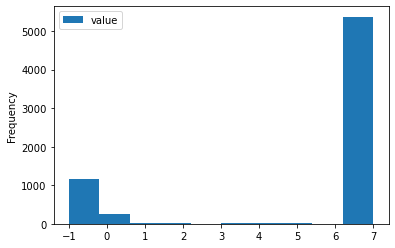

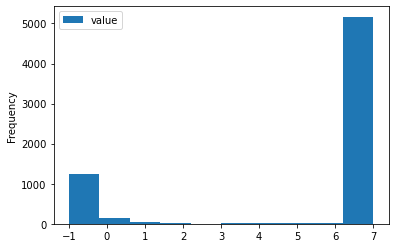

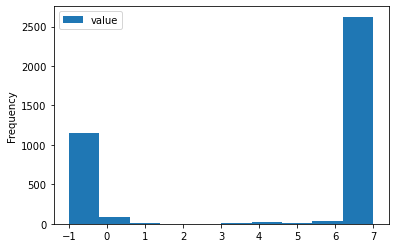

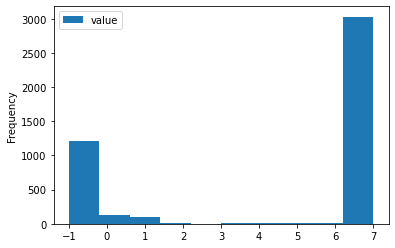

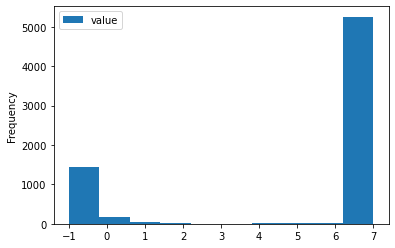

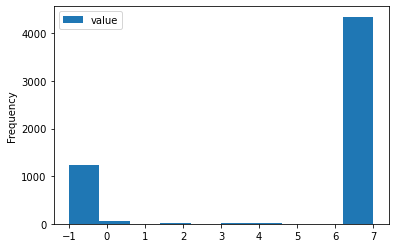

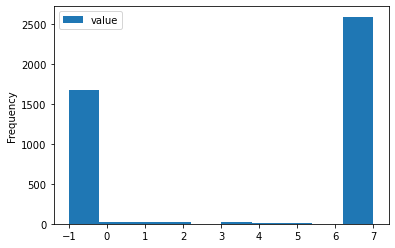

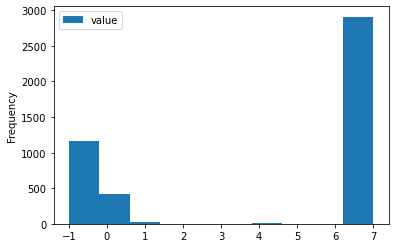

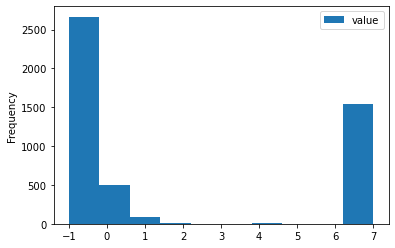

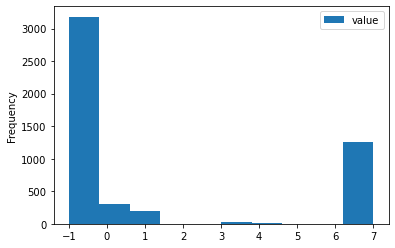

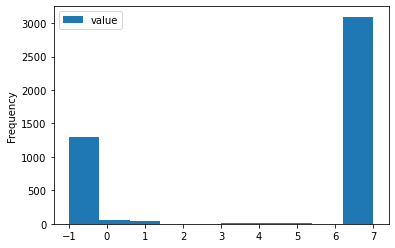

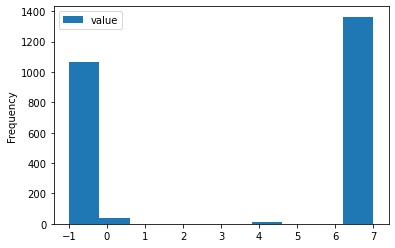

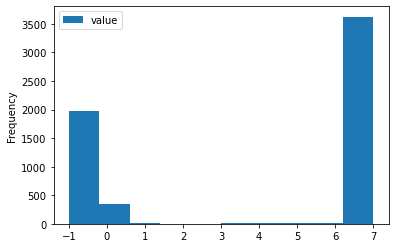

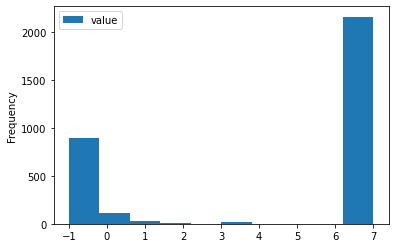

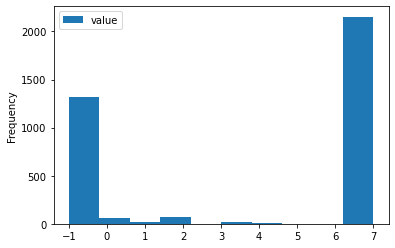

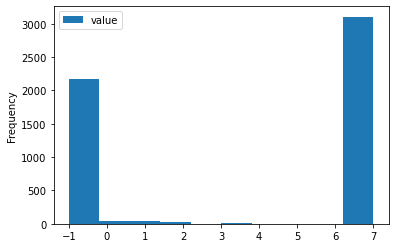

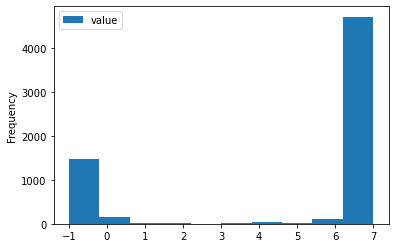

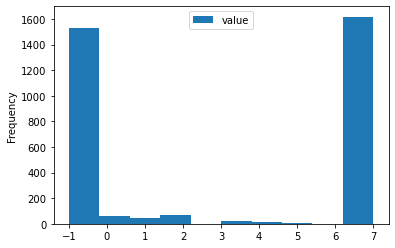

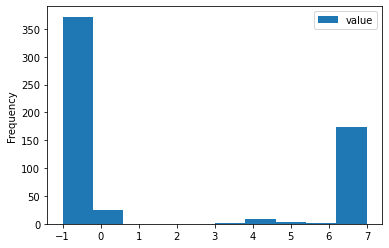

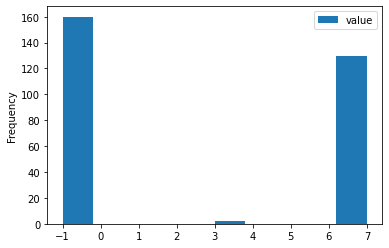

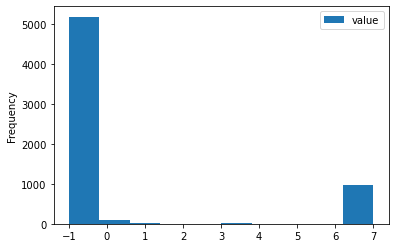

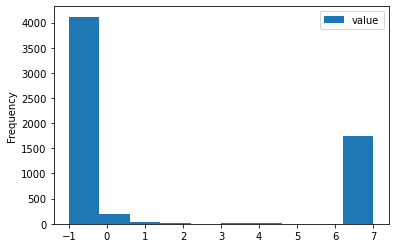

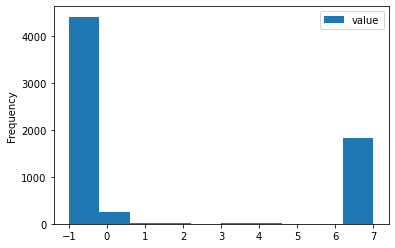

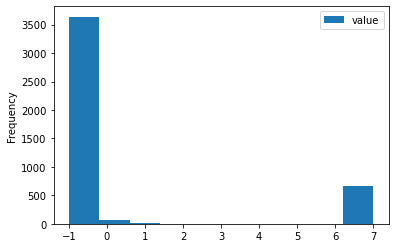

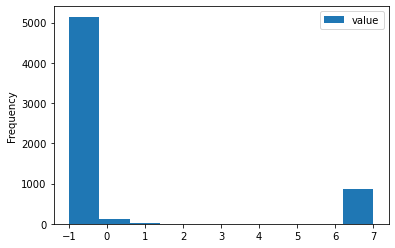

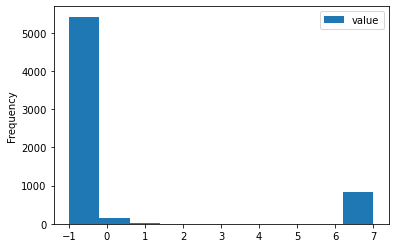

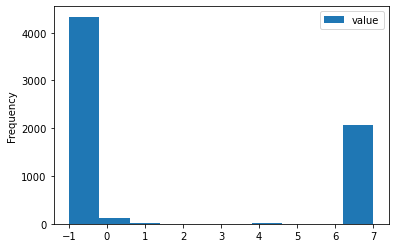

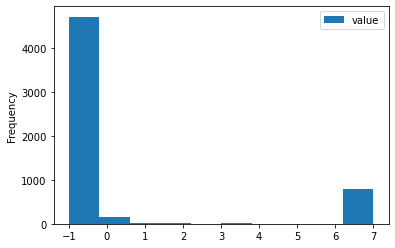

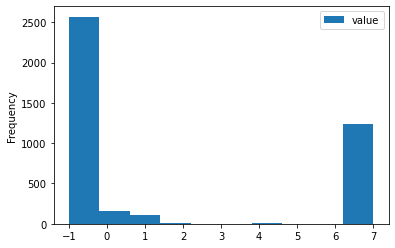

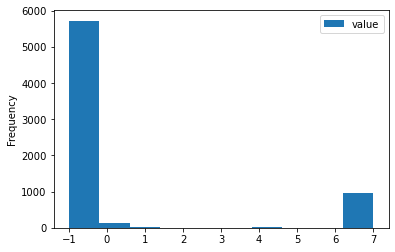

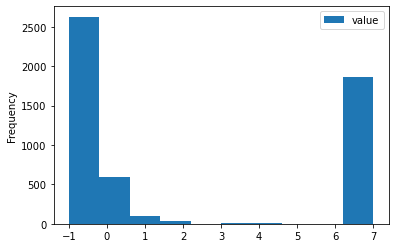

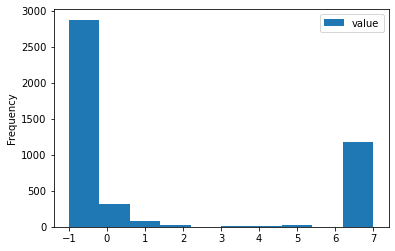

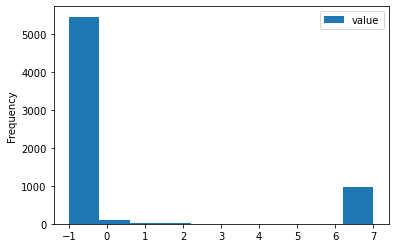

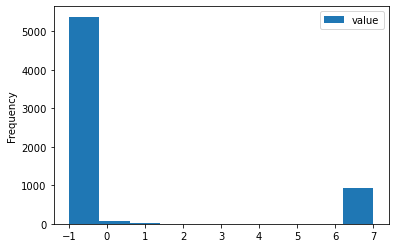

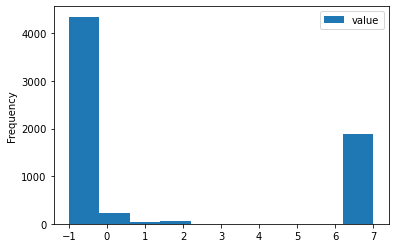

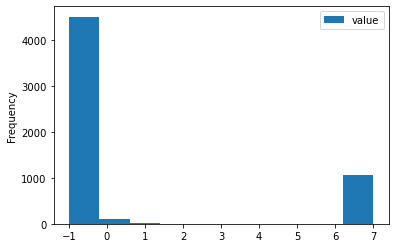

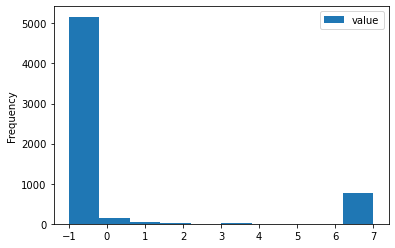

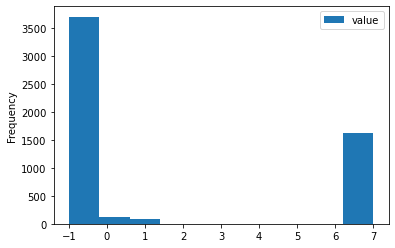

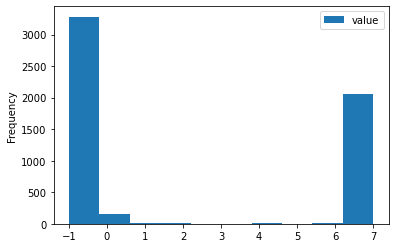

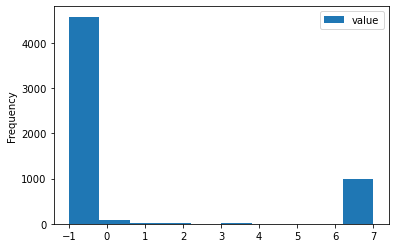

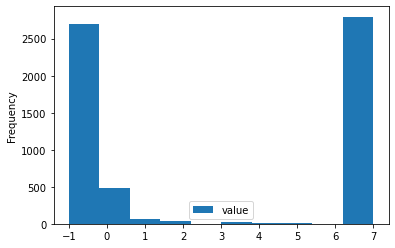

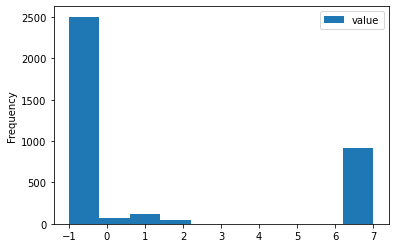

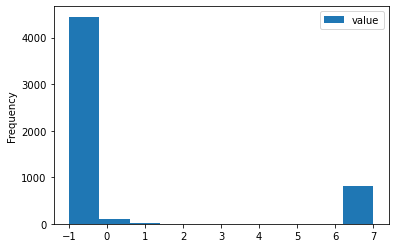

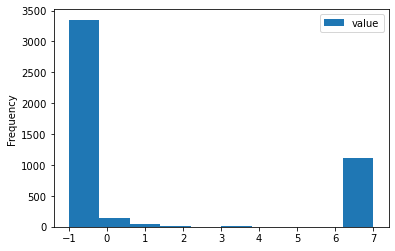

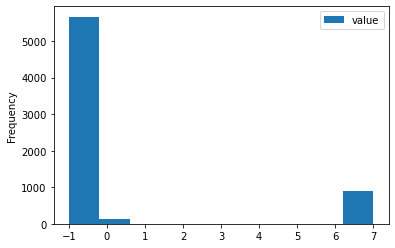

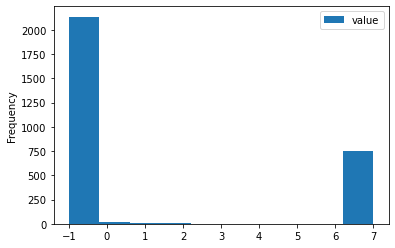

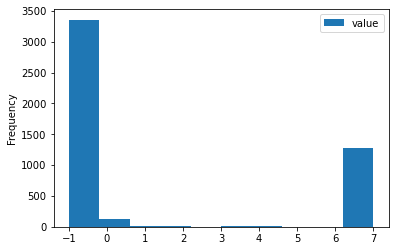

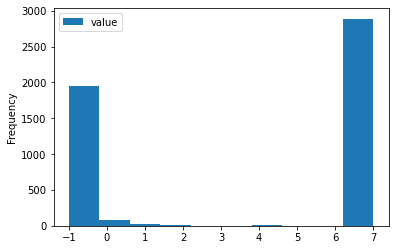

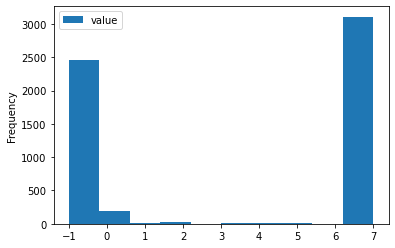

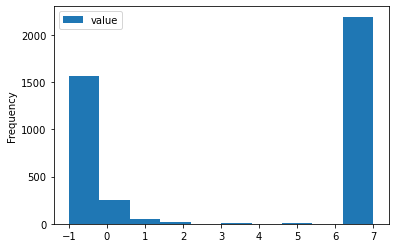

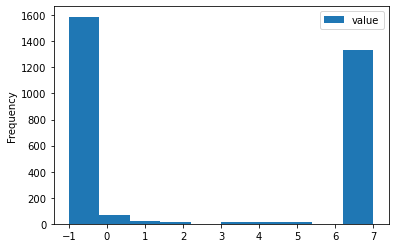

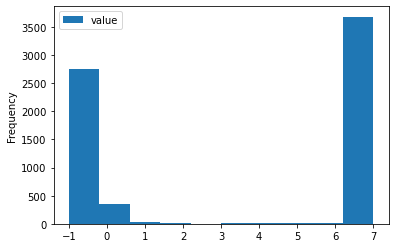

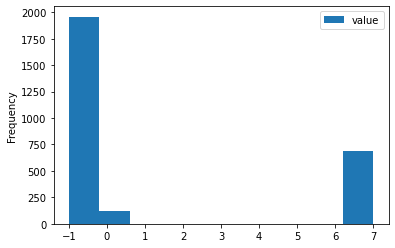

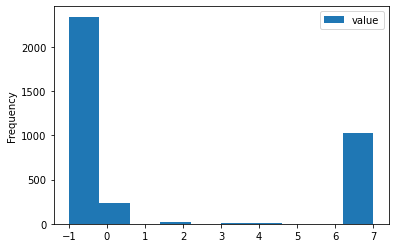

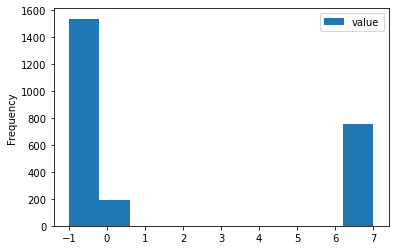

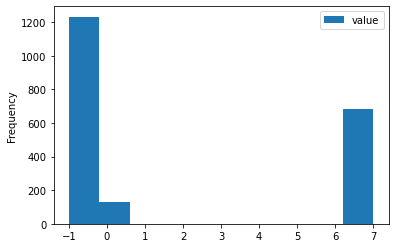

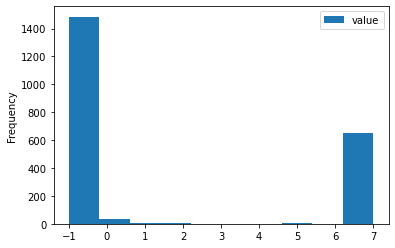

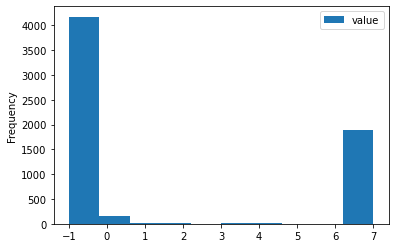

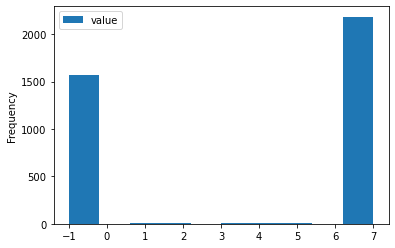

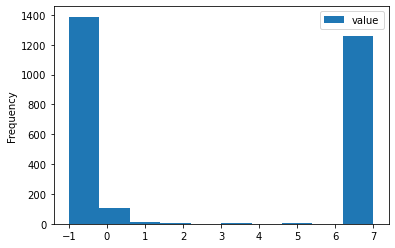

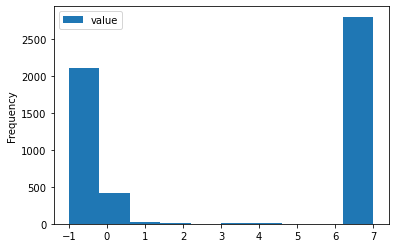

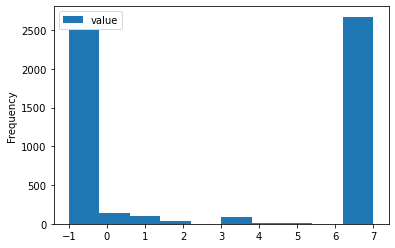

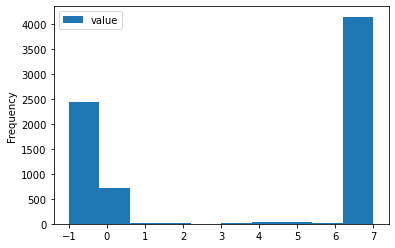

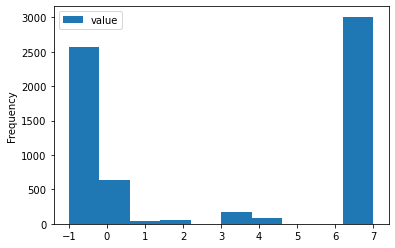

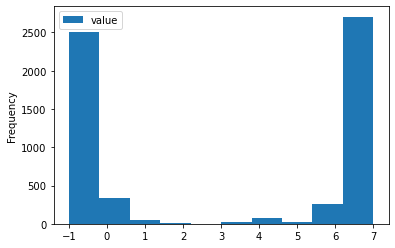

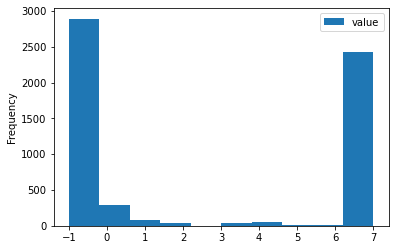

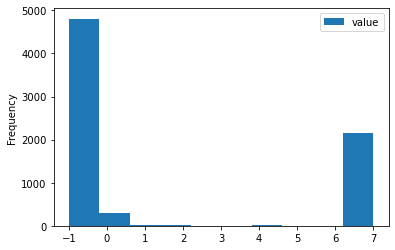

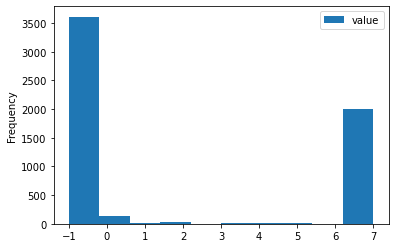

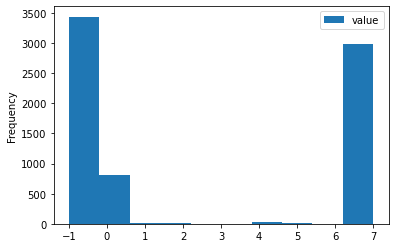

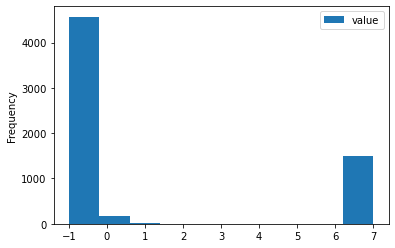

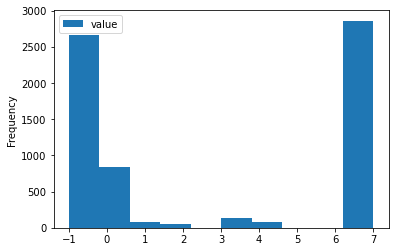

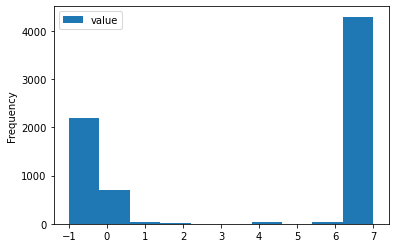

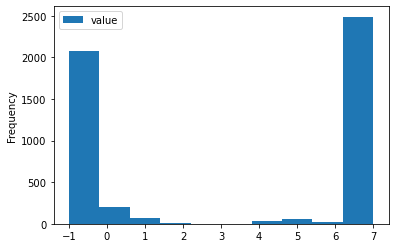

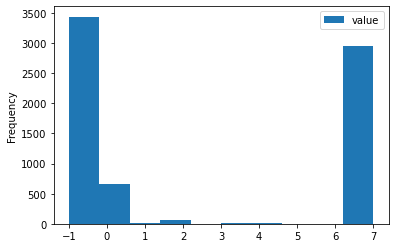

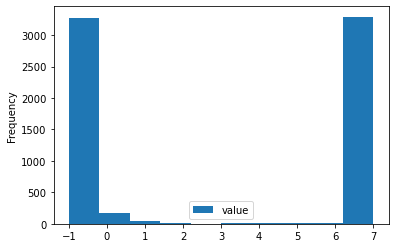

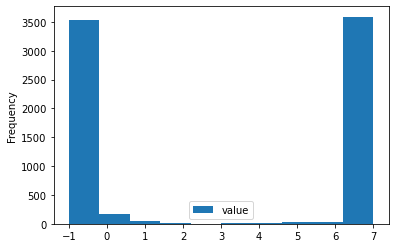

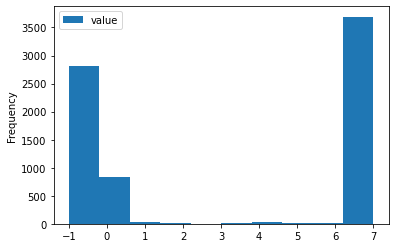

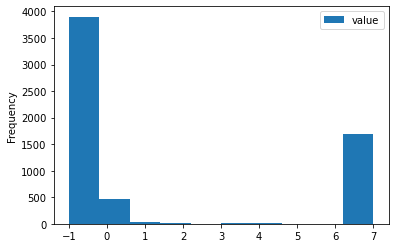

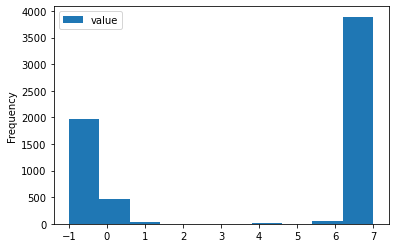

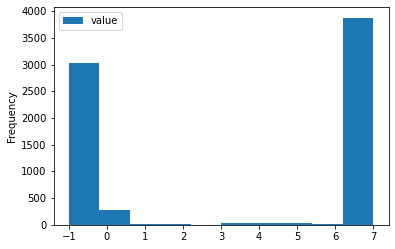

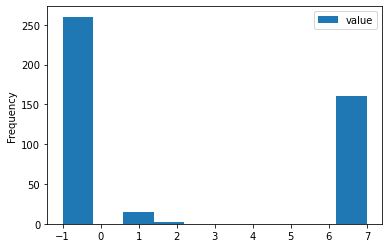

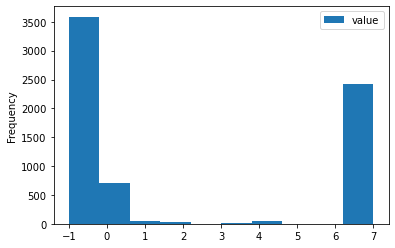

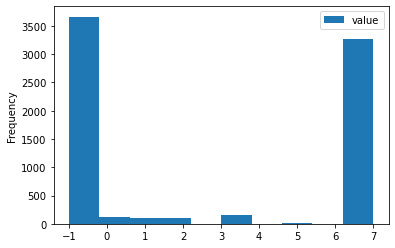

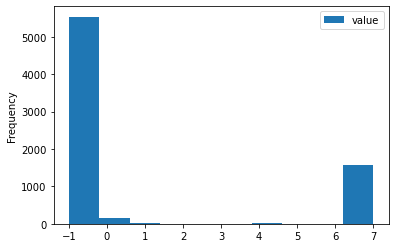

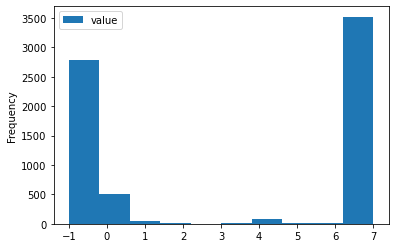

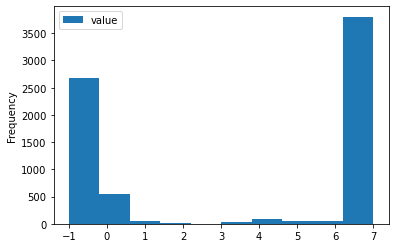

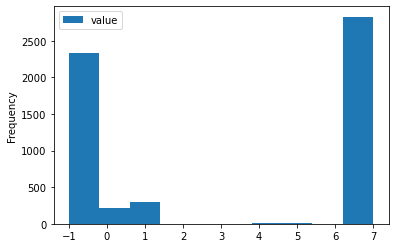

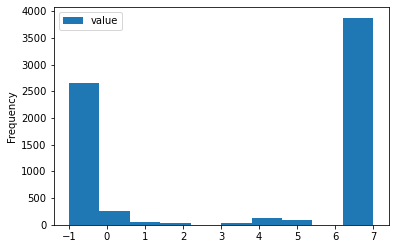

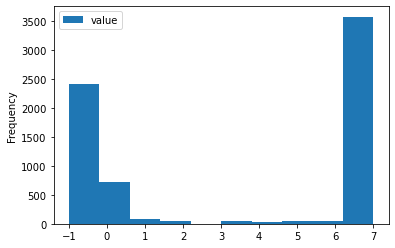

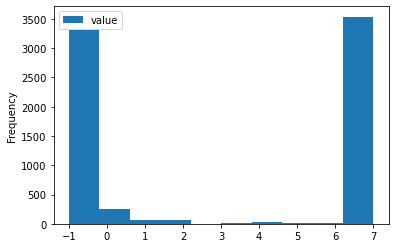

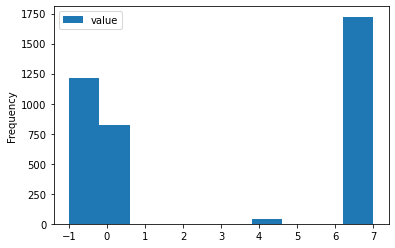

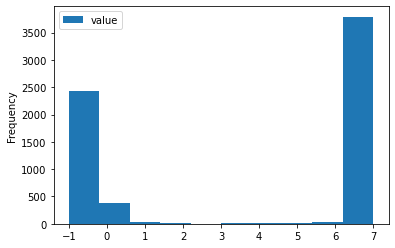

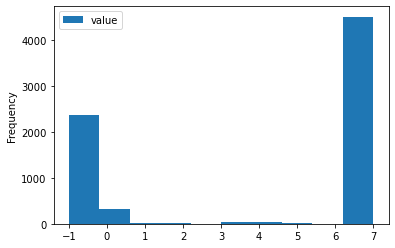

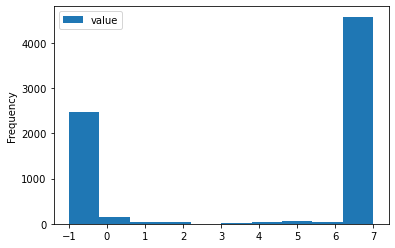

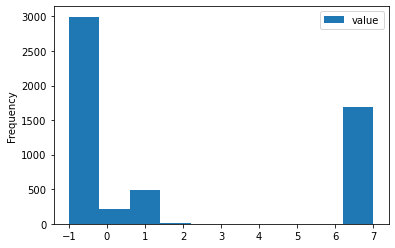

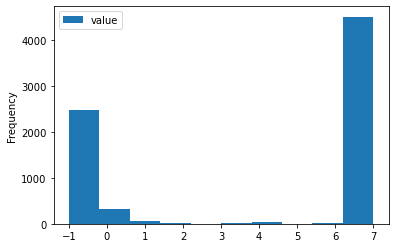

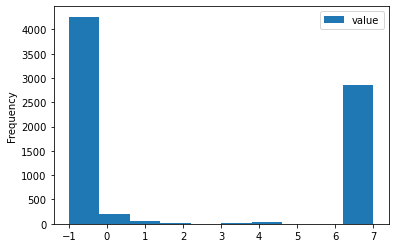

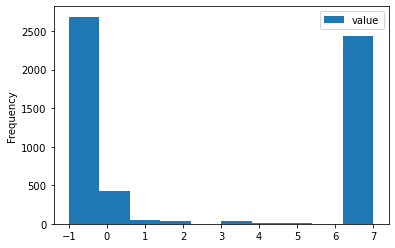

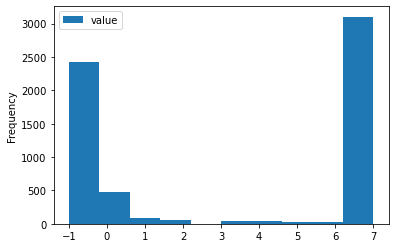

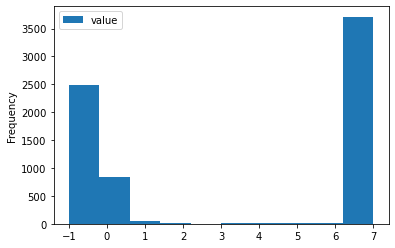

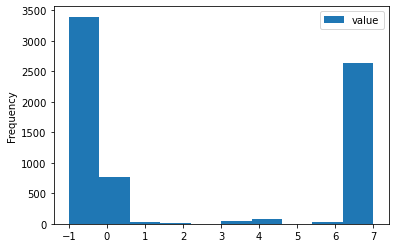

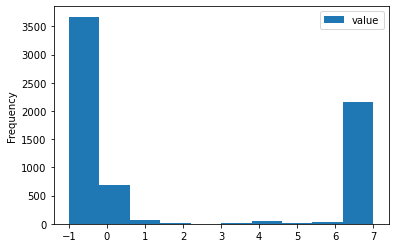

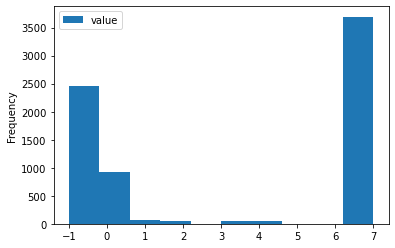

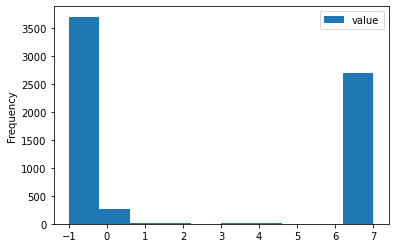

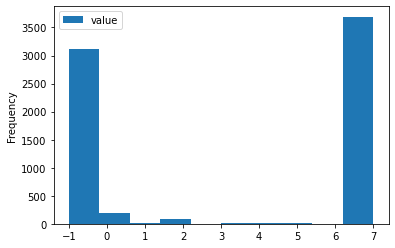

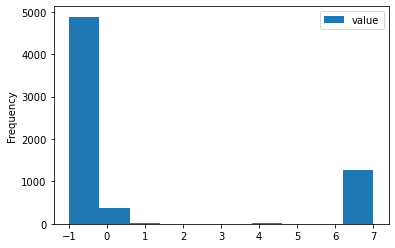

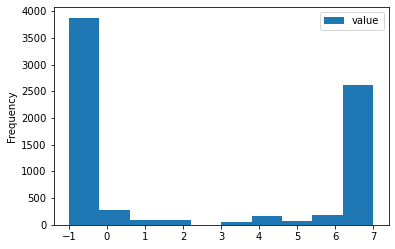

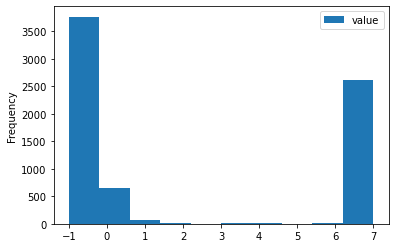

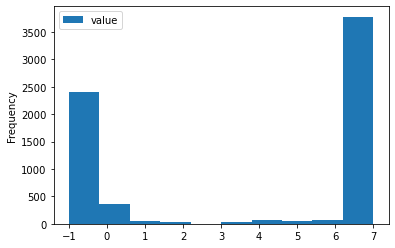

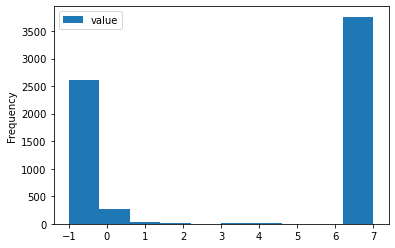

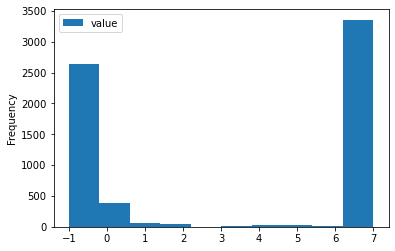

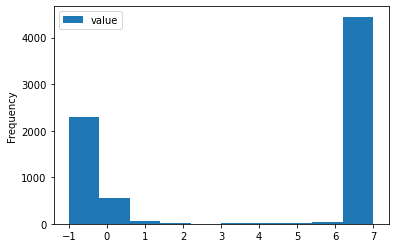

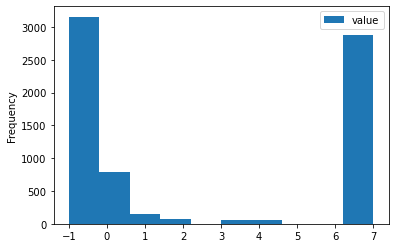

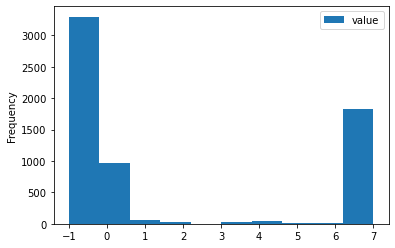

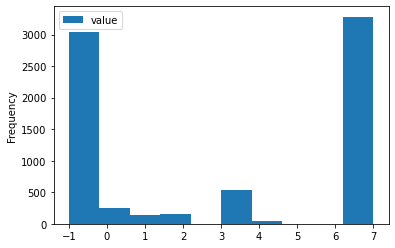

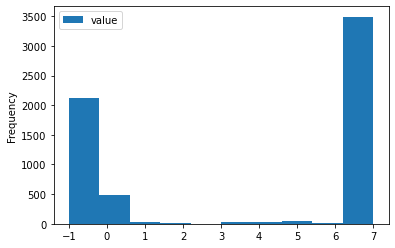

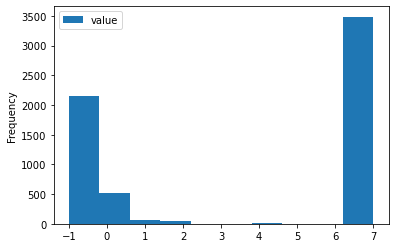

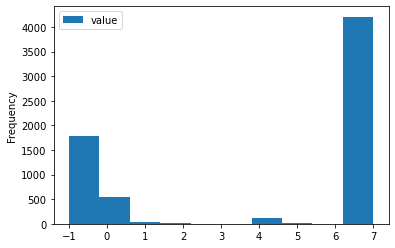

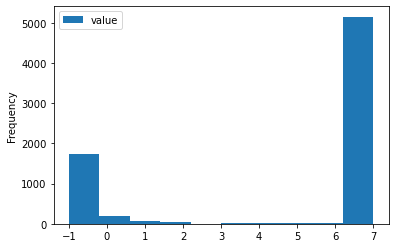

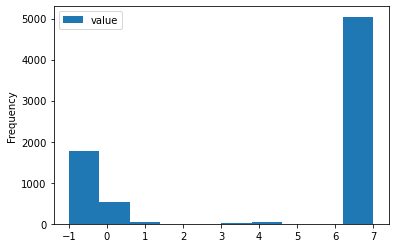

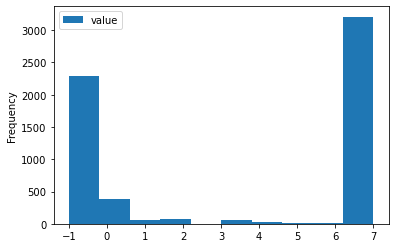

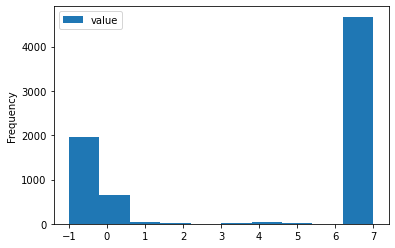

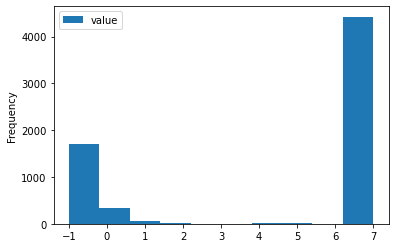

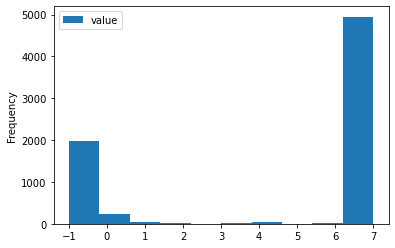

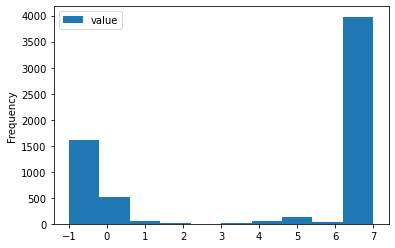

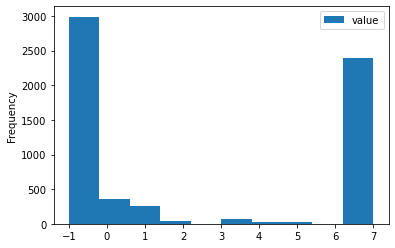

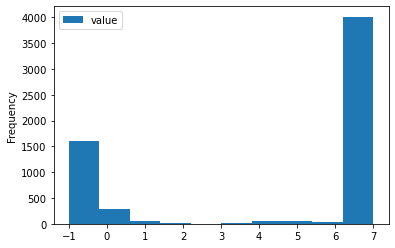

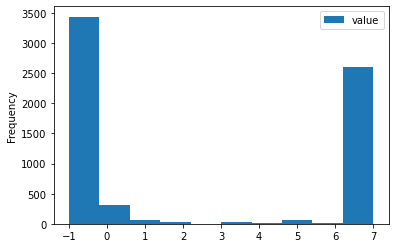

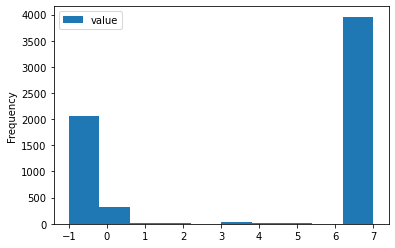

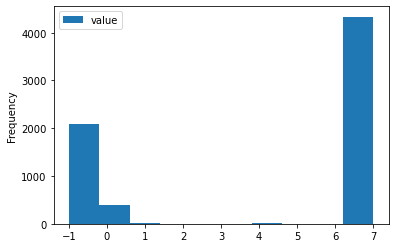

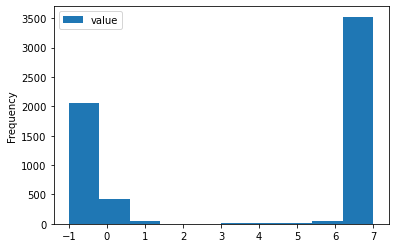

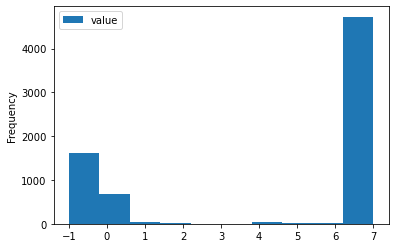

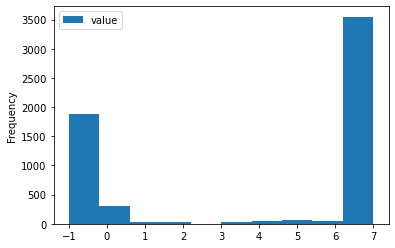

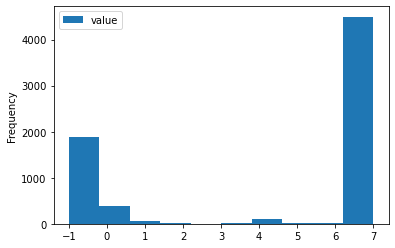

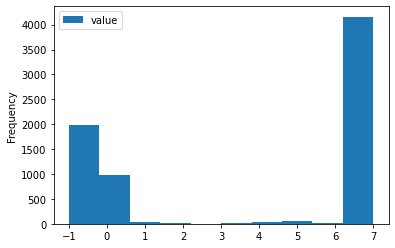

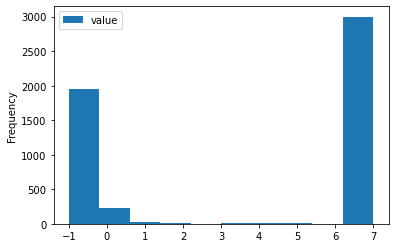

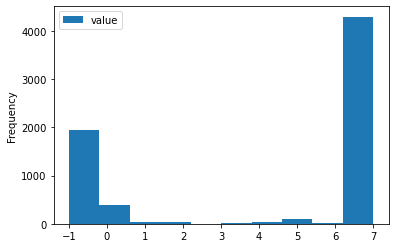

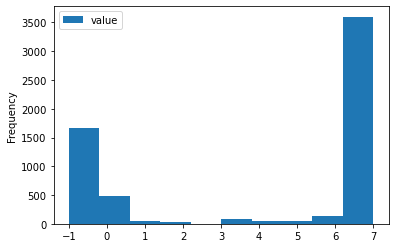

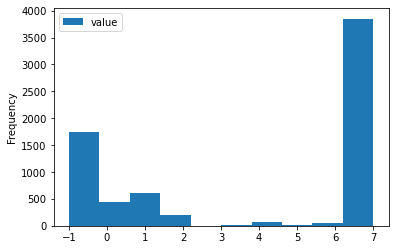

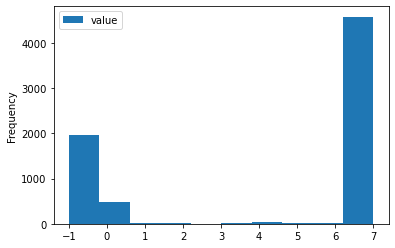

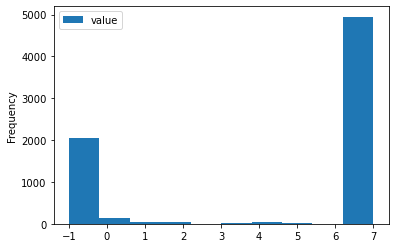

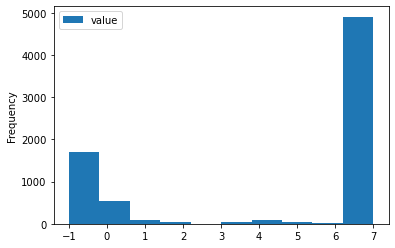

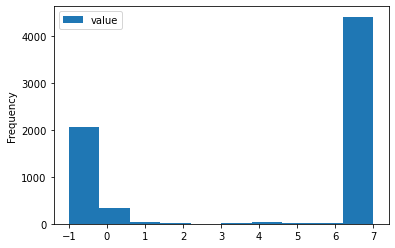

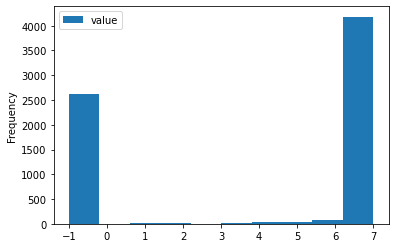

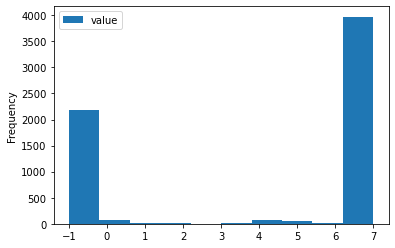

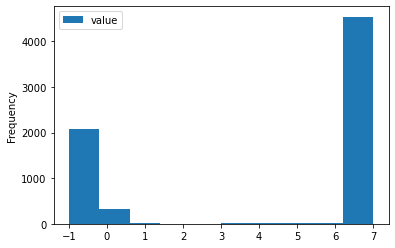

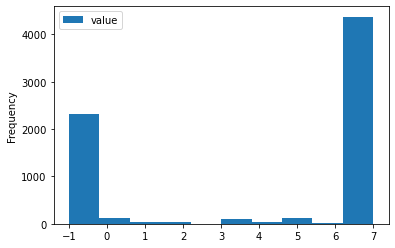

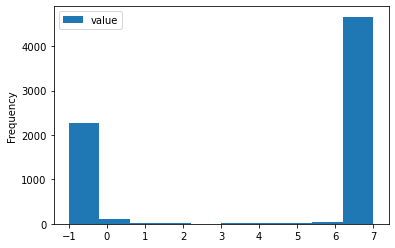

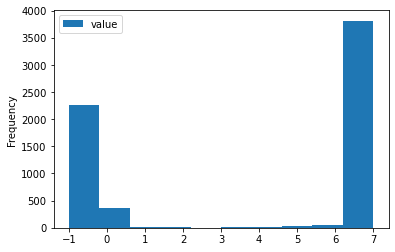

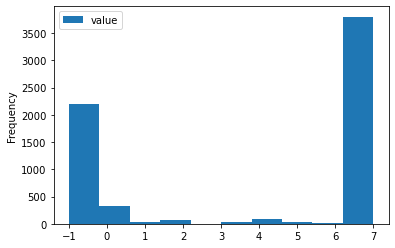

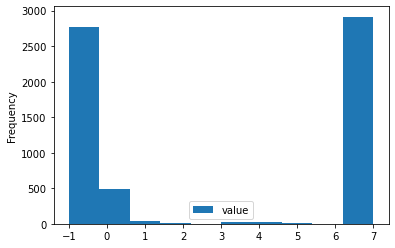

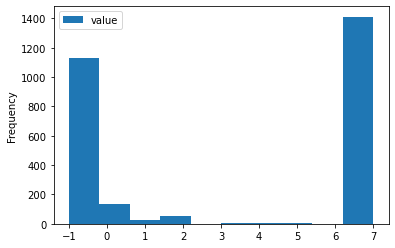

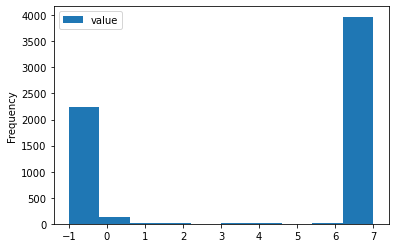

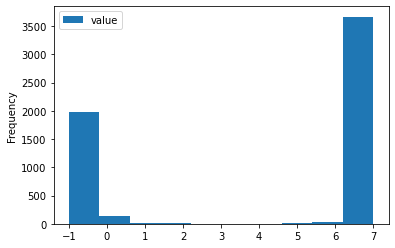

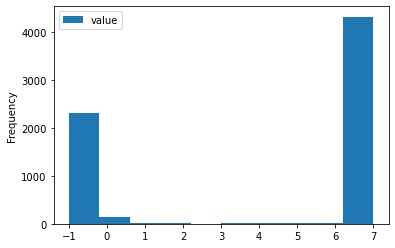

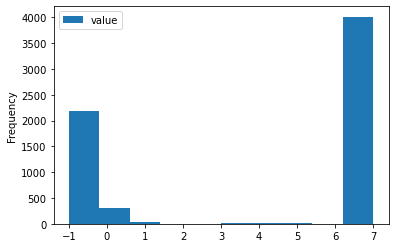

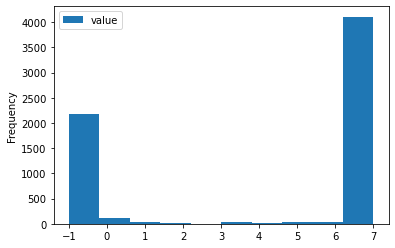

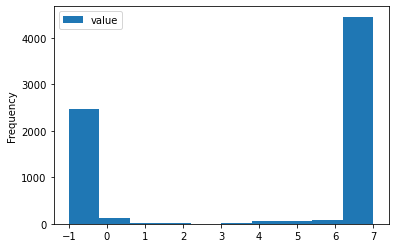

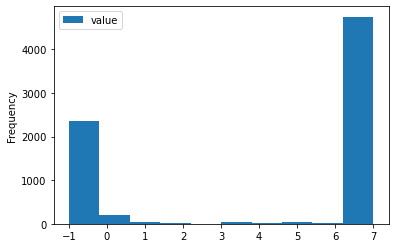

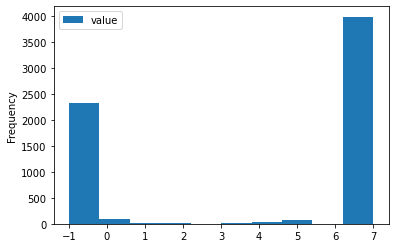

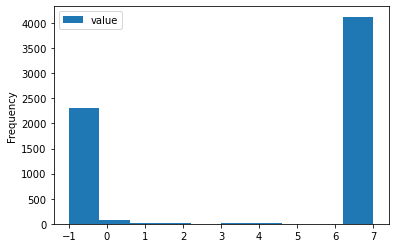

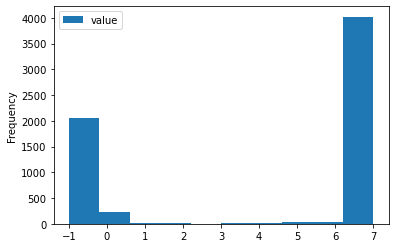

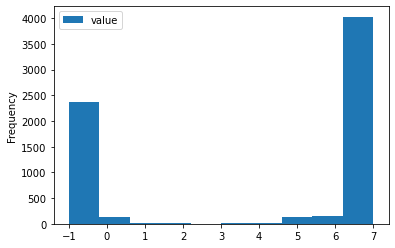

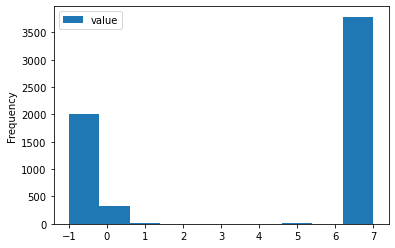

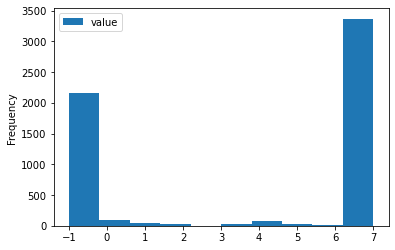

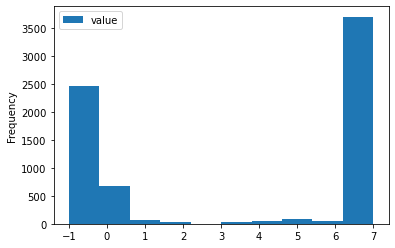

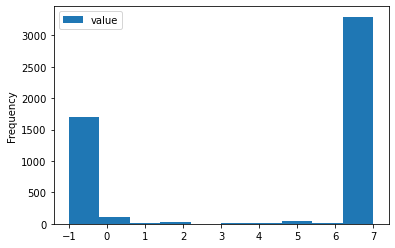

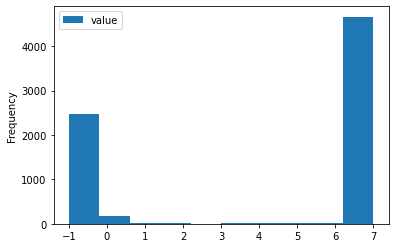

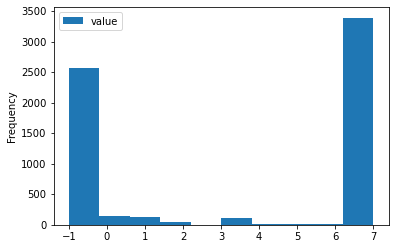

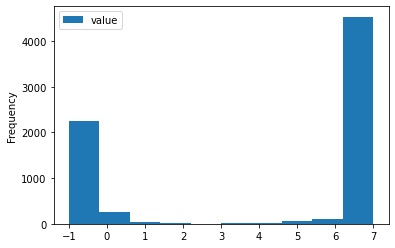

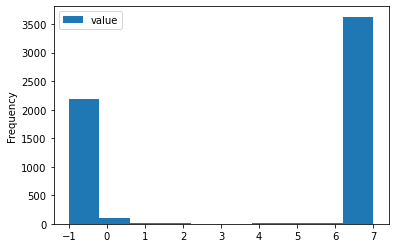

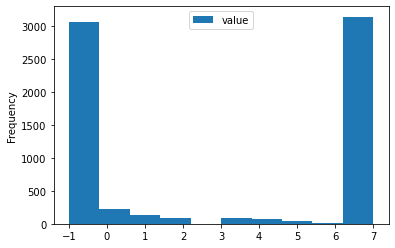

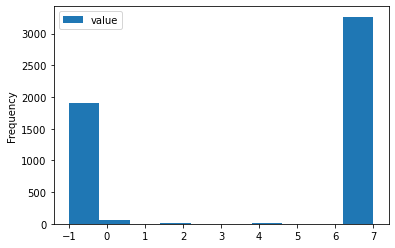

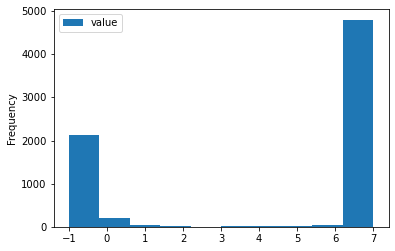

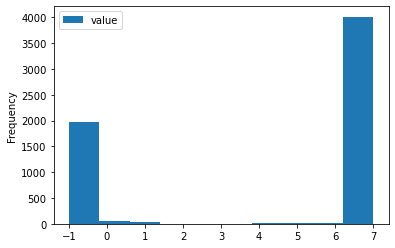

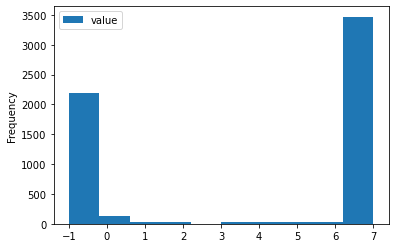

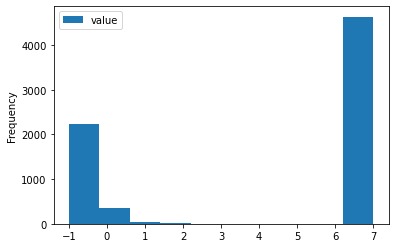

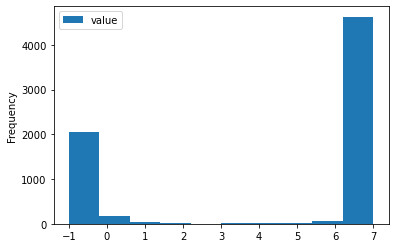

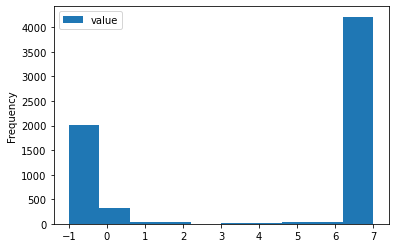

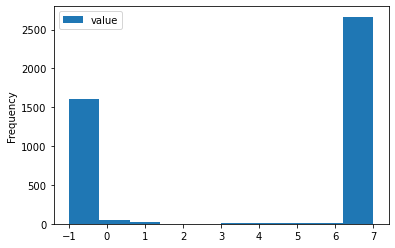

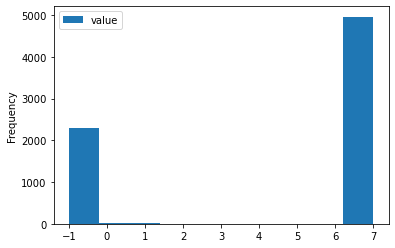

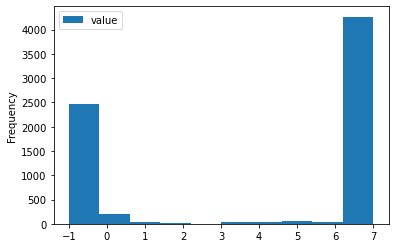

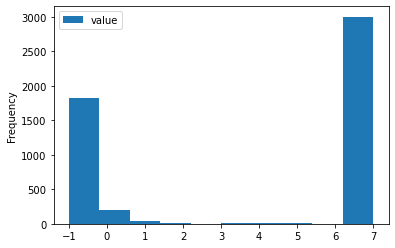

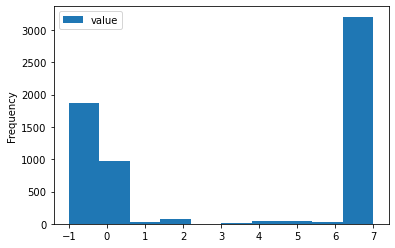

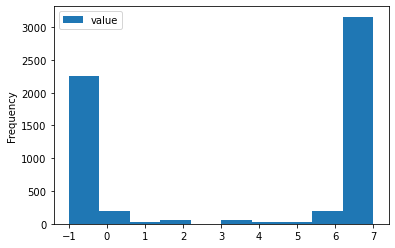

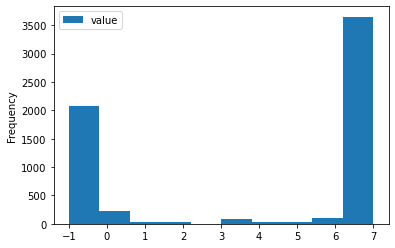

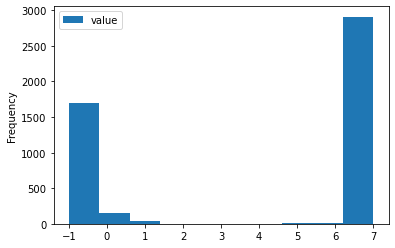

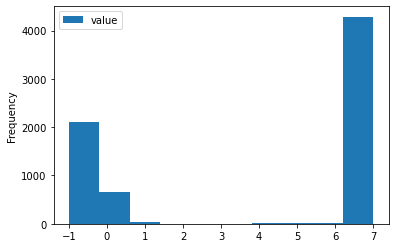

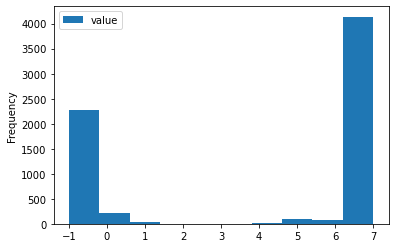

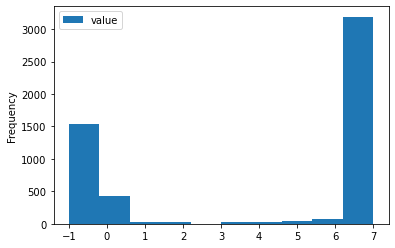

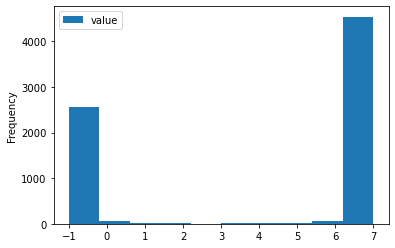

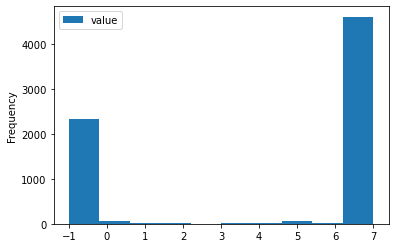

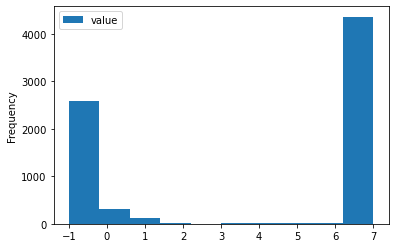

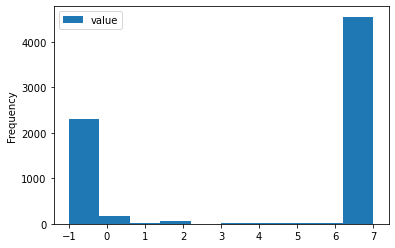

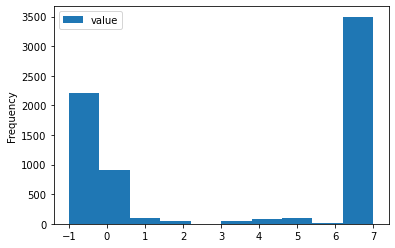

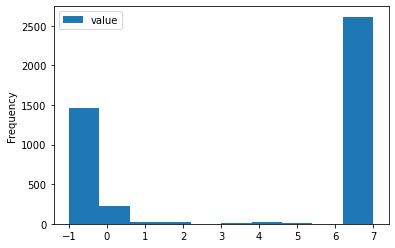

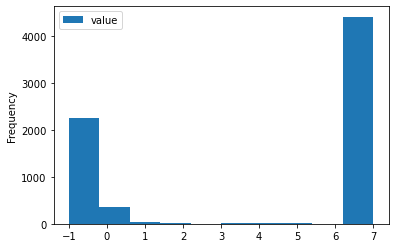

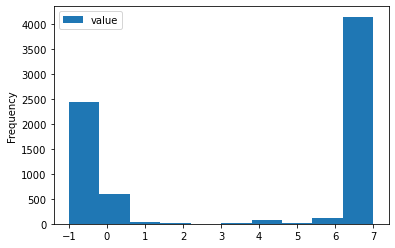

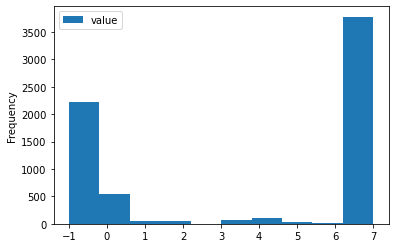

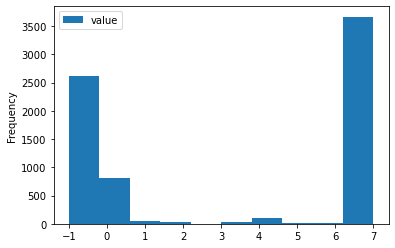

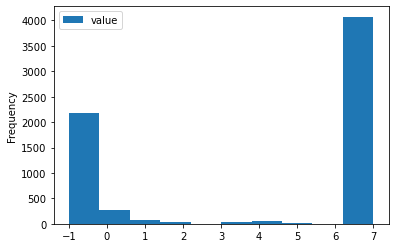

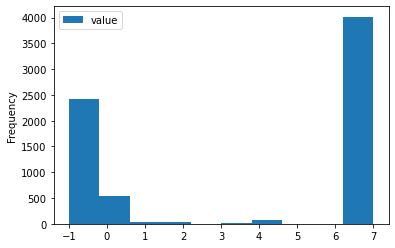

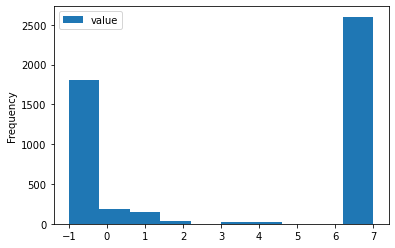

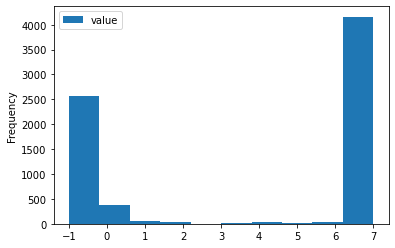

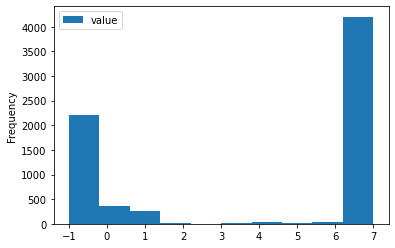

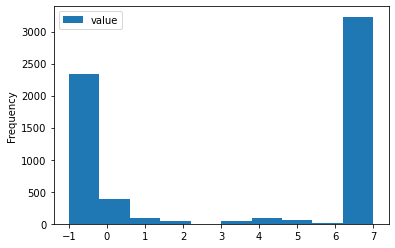

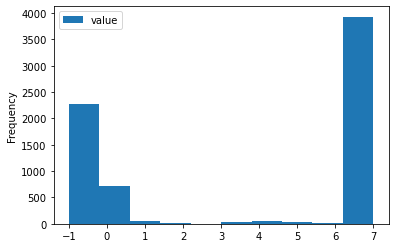

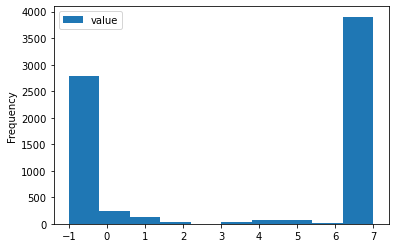

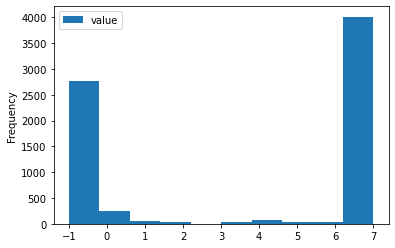

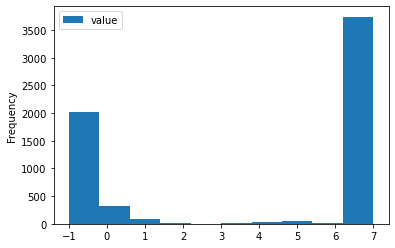

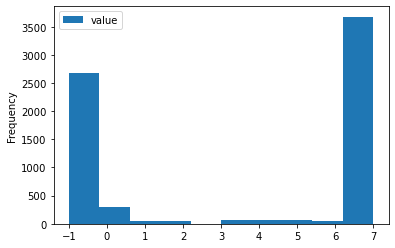

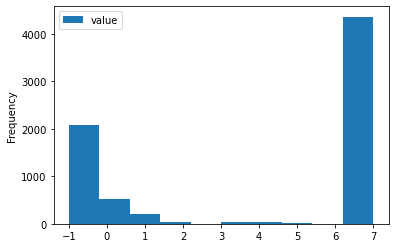

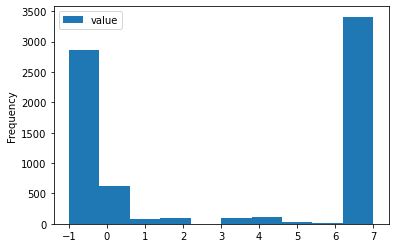

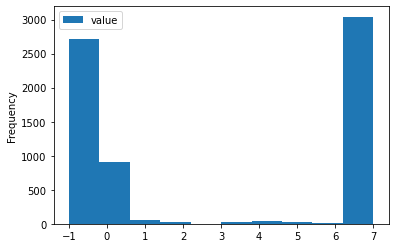

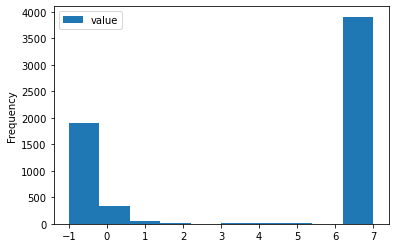

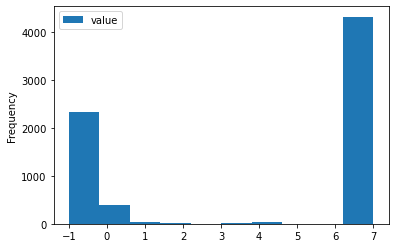

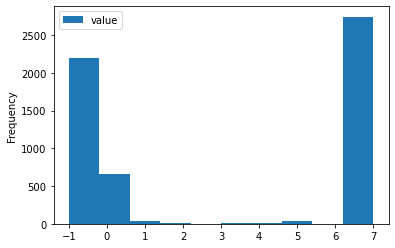

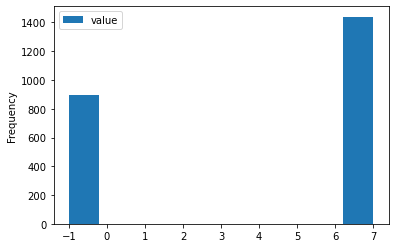

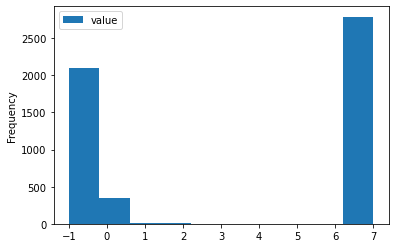

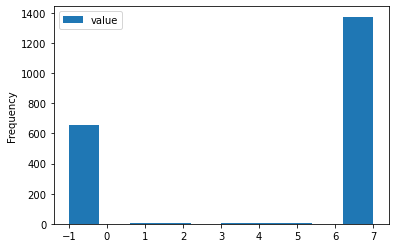

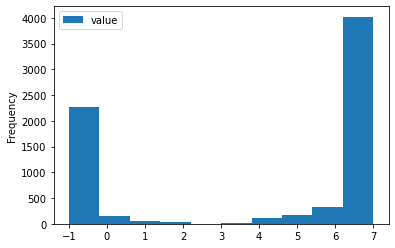

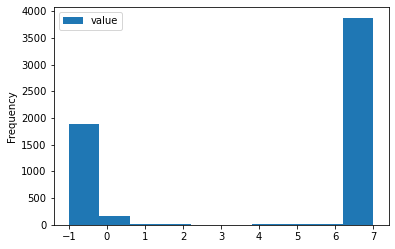

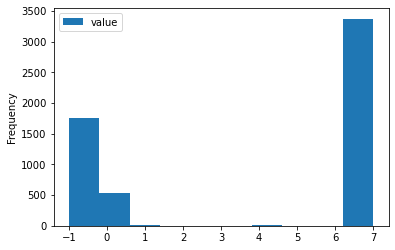

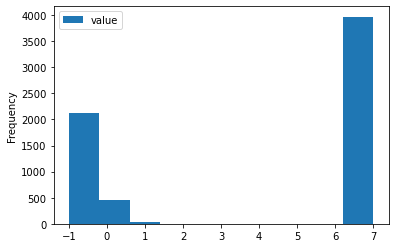

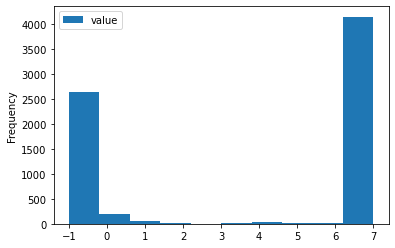

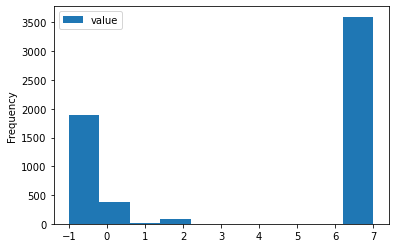

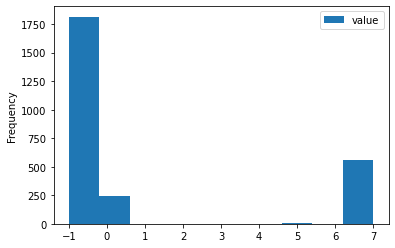

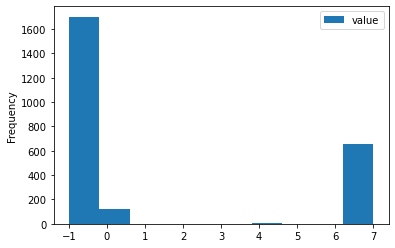

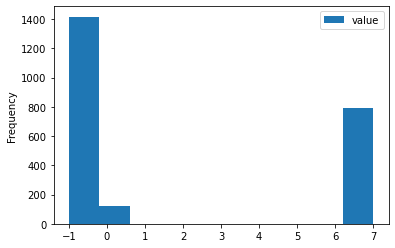

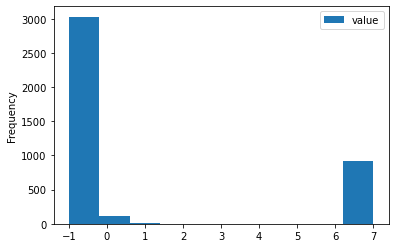

In [13]:
(df_clean.reset_index()[['OUTLET'] + sorted(OSA_cols)]
 .melt(id_vars='OUTLET', 
       value_vars=sorted(OSA_cols))
 .groupby('OUTLET')
 .plot
 .hist('value'))